In [226]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## The Framework of Hypothesis Testing

Hypothesis testing is a core concept in inferential statistics. It provides a structured way to make decisions when faced with uncertainty. A common application is **A/B testing**, where a "control" group is compared to a "treatment" group to determine if a change had a real effect. The fundamental question is always the same: "Is the difference I observed in my sample a real effect, or is it just a result of random sampling variability?"

The process begins with a **hypothesis** about a population parameter. For example, we might hypothesize that the mean annual compensation for a population of data scientists is $110,000.

We then take a sample from that population and calculate a **point estimate** (the sample mean). If our sample mean is very close to the hypothesized mean, we have no reason to doubt the hypothesis. However, if our sample mean is very far from the hypothesized value, we might conclude that our initial hypothesis was wrong.


### Using the Bootstrap Distribution to Estimate Variability

To decide what constitutes "far," we need to understand how much our sample mean is expected to vary by chance alone. The **standard error** quantifies this variability. As we've seen, we can estimate the standard error by generating a **bootstrap distribution** from our sample. The standard deviation of this bootstrap distribution is our best estimate of the standard error.

```python
import pandas as pd
import numpy as np

# Create a generic "sample" DataFrame
np.random.seed(42)
sample = pd.DataFrame({
    'compensation': np.random.normal(loc=120000, scale=50000, size=500)
})

# Generate a bootstrap distribution of the sample mean
bootstrap_dist = []
for i in range(5000):
    bootstrap_sample = sample.sample(frac=1, replace=True, random_state=i)
    bootstrap_dist.append(bootstrap_sample['compensation'].mean())

# The standard deviation of the bootstrap distribution is the standard error
standard_error = np.std(bootstrap_dist, ddof=1)
print(f"Estimated Standard Error: {standard_error:.2f}")
```


### The Z-Score: Standardizing the Difference

The **z-score** is a standardized test statistic that reframes the difference between our sample statistic and the hypothesized parameter in units of standard errors. This allows us to assess how "surprising" our sample result is.

The formula is:
$$z = \frac{\text{Sample Statistic} - \text{Hypothesized Parameter Value}}{\text{Standard Error}}$$

A z-score of 2.5 means our observed sample statistic is 2.5 standard errors away from the hypothesized value.

```python
# Calculate the z-score 

# Our hypothesis about the population
hypothesized_mean = 110000

# Our observed statistic from the sample
sample_mean = sample['compensation'].mean()

# Calculate the z-score
z_score = (sample_mean - hypothesized_mean) / standard_error

print(f"Sample Mean: {sample_mean:.2f}")
print(f"Hypothesized Mean: {hypothesized_mean}")
print(f"Z-score: {z_score:.4f}")
```

### Interpreting the Z-Score

To determine if our z-score is large or small, we compare it to the **standard normal distribution**, which is a normal distribution with a mean of 0 and a standard deviation of 1. If our original hypothesis were true, we would expect our z-score to be a value that could plausibly come from this distribution (i.e., a value close to zero).

A common threshold for statistical significance is a z-score whose absolute value is greater than **1.96**. This value corresponds to the middle 95% of the standard normal distribution. A z-score outside this range is considered unlikely to have occurred by random chance alone if the hypothesis were true.

  * If `|z| > 1.96`, we typically **reject the hypothesis**. The evidence suggests the true population parameter is different from what was hypothesized.
  * If `|z| ≤ 1.96`, we **fail to reject the hypothesis**. The observed difference is small enough that it could plausibly be due to random sampling variability.

In our example, the calculated z-score is greater than 1.96, so we would reject the hypothesis that the true mean compensation is $110,000. Our sample provides strong evidence that the true mean is likely higher.

In [227]:
url = "https://assets.datacamp.com/production/repositories/5982/datasets/c59033b93930652f402e30db77c3b8ef713dd701/stack_overflow.feather"
stack_overflow = pd.read_feather(url)
stack_overflow.head()

,respondent,main_branch,hobbyist,age,age_1st_code,age_first_code_cut,comp_freq,comp_total,converted_comp,country,...,survey_length,trans,undergrad_major,webframe_desire_next_year,webframe_worked_with,welcome_change,work_week_hrs,years_code,years_code_pro,age_cat
0,36.0,"I am not primarily a developer, but I write co...",Yes,34.0,30.0,adult,Yearly,60000.0,77556.0,United Kingdom,...,Appropriate in length,No,"Computer science, computer engineering, or sof...",Express;React.js,Express;React.js,Just as welcome now as I felt last year,40.0,4.0,3.0,At least 30
1,47.0,I am a developer by profession,Yes,53.0,10.0,child,Yearly,58000.0,74970.0,United Kingdom,...,Appropriate in length,No,"A natural science (such as biology, chemistry,...",Flask;Spring,Flask;Spring,Just as welcome now as I felt last year,40.0,43.0,28.0,At least 30
2,69.0,I am a developer by profession,Yes,25.0,12.0,child,Yearly,550000.0,594539.0,France,...,Too short,No,"Computer science, computer engineering, or sof...",Django;Flask,Django;Flask,Just as welcome now as I felt last year,40.0,13.0,3.0,Under 30
3,125.0,"I am not primarily a developer, but I write co...",Yes,41.0,30.0,adult,Monthly,200000.0,2000000.0,United States,...,Appropriate in length,No,None,None,None,Just as welcome now as I felt last year,40.0,11.0,11.0,At least 30
4,147.0,"I am not primarily a developer, but I write co...",No,28.0,15.0,adult,Yearly,50000.0,37816.0,Canada,...,Appropriate in length,No,"Another engineering discipline (such as civil,...",None,Express;Flask,Just as welcome now as I felt last year,40.0,5.0,3.0,Under 30


### Hypothesizing about the mean
A hypothesis:
> The mean annual compensation of the population of data scientists is $110,000

In [228]:
mean_comp_samp = stack_overflow["converted_comp"].mean()
print(mean_comp_samp)

119574.71738168952


The result is different from our hypothesis, but is it meaningfully different? To answer this, we need to generate a bootstrap distribution of sample means. This is done by resampling the dataset, calculating the sample mean for that resample, then repeating those steps to create a list of sample means.

In [229]:
# Generating a bootstrap distribution
# This simulates the sampling distribution of the mean compensation by repeatedly resampling (with replacement)
# from the stack_overflow dataset and calculating the mean for each resample.
so_boot_distn = [
    np.mean(stack_overflow.sample(frac=1, replace=True)["converted_comp"])
    for _ in range(5000)
]

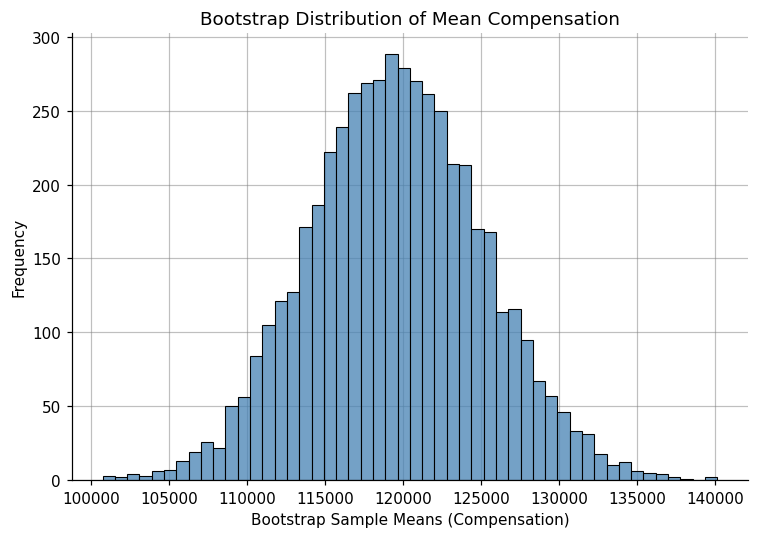

In [230]:
# Plotting the bootstrap distribution of sample means for compensation
fig, ax = plt.subplots(figsize=(7, 5), dpi=110)

# Plot a histogram of the bootstrap sample means
sns.histplot(so_boot_distn, bins=50, ax=ax, color="steelblue", edgecolor="black")
sns.despine()

# Set axis labels and title
ax.set(
    xlabel="Bootstrap Sample Means (Compensation)",
    ylabel="Frequency",
    title="Bootstrap Distribution of Mean Compensation",
)

# Add gridlines
ax.grid(True, alpha=0.5, linewidth=0.8, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### 1. Bootstrap Standard Error ($SE_{\text{boot}}$)

**Definition**: The bootstrap SE is an empirical estimate of the standard deviation of the sampling distribution of $\hat p$, obtained by repeatedly resampling the original data with replacement and computing the variability of the resampled proportions. It approximates the SE without assuming a specific parametric form. This method, introduced by Bradley Efron in 1979, uses computation to mimic sampling from the population by treating the sample as a proxy for the population.

**Formula**:

$$
SE_{\text{boot}}
= \sqrt{\frac{1}{B-1}\sum_{b=1}^{B}\big(\hat p_b^{*}-\bar{\hat p}^{*}\big)^{2}},
\qquad
\bar{\hat p}^{*}=\frac{1}{B}\sum_{b=1}^{B}\hat p_b^{*}.
$$

**Calculation Steps**:

1. Start with your sample data (e.g., a vector of $n$ binary outcomes).
2. For each of $B$ replicates:
   * Draw a bootstrap sample: randomly select $n$ observations with replacement.
   * Compute the proportion $\hat p_b^{*}$ in that sample.
3. Compute the sample standard deviation of the $B$ values $\{\hat p_b^{*}\}_{b=1}^{B}$ using the divisor $B-1$.

**When to Use**:

* When a nonparametric estimate is preferred that does not assume normality or a binomial model; useful for small samples, skewed data, or for validating parametric SEs.
* Commonly used for confidence intervals (e.g., percentile bootstrap CI) or as a check against $SE_{\hat p}$.
* Avoid when $n$ is very small (e.g., $<20$–$30$), because bootstrap may underestimate variability; also avoid if computation is severely constrained.





In [231]:
# Set the random seed for reproducibility of random numbers
np.random.seed(42)

# Simulate 1000 Bernoulli trials with success probability 0.4; returns 1 for success, 0 for failure
is_success = np.random.binomial(1, 0.4, 1000)

# Calculate the sample size (number of trials)
n = is_success.size

# Number of bootstrap samples to generate
B = 1000

# Generate bootstrap indices: random sampling with replacement, creating B resamples of size n
boot_indices = np.random.choice(n, size=(B, n), replace=True)

# Calculate the proportion of successes for each bootstrap sample
boot_proportions = is_success[boot_indices].mean(axis=1)

# Calculate the bootstrap standard error (SE): standard deviation of bootstrap proportions
SE_boot = boot_proportions.std(ddof=1)

# Print the bootstrap standard error rounded to 4 decimal places
print(f"Bootstrap SE: {SE_boot:.4f}")

Bootstrap SE: 0.0151


**Notes**:

* Pros: Flexible, minimal assumptions; handles complex statistics beyond proportions.
* Cons: Computationally heavier than a closed-form plug-in; may be biased in very small samples.
* Pedagogical point: If $SE_{\text{boot}}$ aligns with $SE_{\hat p}$, that supports the usual normal approximation in your setting.



### 2. Plug-in (Estimated) Standard Error ($SE_{\hat p}$)

**Definition**: The plug-in (asymptotic) SE is a parametric estimate derived from the variance of the binomial proportion under a normal approximation. It plugs in the sample proportion $\hat p$ into the theoretical formula, assuming a binomial model.

**Formula**:

$$
SE_{\hat p}=\sqrt{\frac{\hat p(1-\hat p)}{n}}, \qquad \hat p=\frac{1}{n}\sum_{i=1}^{n} y_i.
$$

**Calculation Steps**:

1. Compute the sample proportion $\hat p$.
2. Evaluate $\sqrt{\hat p(1-\hat p)/n}$.

**When to Use**:

* For quick estimation of variability and for constructing standard Wald-type confidence intervals: $\hat p \pm z^{*}SE_{\hat p}$ (e.g., $z^{*}\approx 1.96$ for 95%).
* Requires large-sample conditions such as $n\hat p \ge 10$ and $n(1-\hat p)\ge 10$.

In [232]:
# Set the random seed for reproducibility of random numbers
np.random.seed(42)

# Simulate 1000 Bernoulli trials with success probability 0.4; returns 1 for success, 0 for failure
is_success = np.random.binomial(1, 0.4, 1000)

# Calculate the sample size (number of trials)
n = is_success.size

# Calculate the sample proportion of successes (p̂ = x/n)
p_hat = is_success.mean()

# Calculate the plug-in standard error (SE) for the sample proportion
# Formula: SE(p̂) = sqrt(p̂ * (1 - p̂) / n), where p̂ is the sample proportion
SE_hat = np.sqrt(p_hat * (1 - p_hat) / n)

# Print the plug-in standard error rounded to 4 decimal places
print(f"Plug-in SE: {SE_hat:.4f}")

Plug-in SE: 0.0154




**Notes**:

* Pros: Simple, fast, consistent as $n \to \infty$.
* Cons: Can be inaccurate for small $n$ or extreme $\hat p$ near $0$ or $1$; the Wilson or Agresti–Coull intervals are usually superior for small to moderate $n$.



### 3. Null-Based Standard Error ($SE_{\text{null}}$)

**Definition**: The null-based SE is used in hypothesis testing when the null hypothesis is $H_{0}: p = p_{0}$. It computes variability assuming the null is true so that the test statistic is correctly standardised under $H_{0}$.

**Formula**:

$$
SE_{\text{null}}=\sqrt{\frac{p_{0}(1-p_{0})}{n}}.
$$

**Calculation Steps**:

1. Specify $p_{0}$ from $H_{0}$.
2. Evaluate $\sqrt{p_{0}(1-p_{0})/n}$.

**When to Use**:

* Exclusively for one-sample proportion tests (one-sided or two-sided), with

  $$
  z=\frac{\hat p - p_{0}}{SE_{\text{null}}}.
  $$
* Requires large-sample conditions relative to $p_{0}$ (e.g., $n p_{0}\ge 10$ and $n(1-p_{0})\ge 10$).




In [233]:
n = 1000  # Sample size (number of observations)
p_hat = 0.42  # Observed sample proportion
p0 = 0.35  # Hypothesized population proportion under the null hypothesis

# Calculate the standard error (SE) under the null hypothesis
SE_null = np.sqrt(p0 * (1 - p0) / n)  # Formula: sqrt(p0 * (1 - p0) / n)

# Calculate the z-score: standardized difference between observed and hypothesized proportions
z_score = (p_hat - p0) / SE_null  # Formula: (p_hat - p0) / SE_null

print(f"Null-based SE: {SE_null:.4f}")

print(f"Z-score: {z_score:.4f}")

Null-based SE: 0.0151
Z-score: 4.6410



**Notes**:

* Pros: Calibrates tests correctly under $H_{0}$ and is straightforward to compute.
* Cons: Not for estimation or confidence intervals; if $p_{0}$ is far from $\hat p$ the value will differ noticeably from $SE_{\hat p}$, which is precisely why it should be reserved for testing.
 with Markdown+Math extension).

Since variables have arbitrary units and ranges, before we test our hypothesis, we need to standardize the values. 
A common way of standardizing values is to subtract the mean, and divide by the standard deviation. 

$$\text{standardised value}=\frac{\text{value}-\text{mean}}{\text{standard deviation}}$$

For hypothesis testing, we use a variation where we take the sample statistic, subtract the hypothesized parameter value, and divide by the standard error. The result is called a z-score.

$$z=\frac{\text{sample statistic}-\text{hypothesised parameter value}}{\text{standard error}}$$


In [234]:
# Set the hypothesized mean compensation (the value under the null hypothesis)
mean_comp_hyp = 110_000

# Calculate the sample mean compensation from the Stack Overflow dataset
mean_comp_samp = stack_overflow["converted_comp"].mean()

# Estimate the standard error using the standard deviation of the bootstrap distribution
std_error = np.std(so_boot_distn, ddof=1)

# Calculate the z-score: how many standard errors the observed mean is from the hypothesized mean
z_score = (mean_comp_samp - mean_comp_hyp) / std_error

# Print the z-score; a higher absolute value indicates a greater difference from the hypothesized mean
print(z_score)

1.7220827037549484


### Testing the hypothesis:
- Is 1.70169 a high or low number?

#### Hypothesis testing use case:
> Determine whether sample statistics are close to or far away from epected (or "hypothesized" values)

Here's a plot of the probability density function for the standard normal distribution, which is a normal distribution with mean of zero and standard deviation of one. 

It's often called the z-distribution, and z-scores are related to this distribution. 

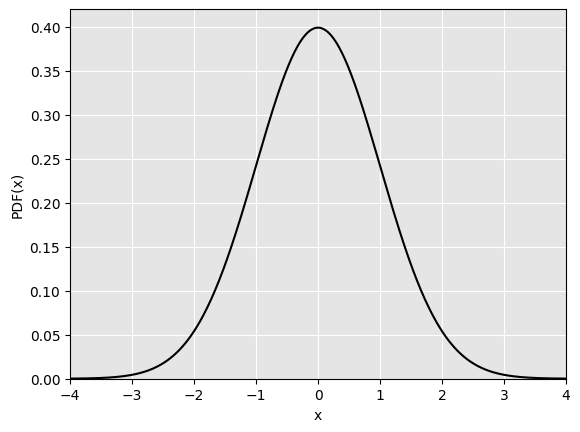

In [235]:
from scipy.stats import norm

# Data for the normal distribution
x = np.linspace(-4, 4, 500)
y = norm.pdf(x, 0, 1)  # Mean = 0, Standard deviation = 1

fig, ax = plt.subplots()
ax.plot(x, y, color="black", linewidth=1.5)

# Axis labels
ax.set_xlabel("x")
ax.set_ylabel("PDF(x)")

# Grid style similar to ggplot2 in R
ax.set_facecolor("#E5E5E5")
ax.grid(True, color="white")
ax.set_axisbelow(True)

ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.42])

plt.show()

In [236]:
url = "https://assets.datacamp.com/production/repositories/5982/datasets/887ec4bc2bcfd4195e7d3ad113168555f36d3afa/late_shipments.feather"
late_shipments = pd.read_feather(url)

### Calculating the sample mean
The late_shipments dataset contains supply chain data on the delivery of medical supplies. Each row represents one delivery of a part. The `late` columns denotes whether or not the part was delivered late. A value of `"Yes"` means that the part was delivered late, and a value of `"No"` means the part was delivered on time.

In [237]:
# Print the late_shipments dataset.
late_shipments.head()

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,25.0,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,22925.0,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,152535.0,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,850.0,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01


In [238]:
# Calculate the proportion of late shipments in the sample; that is, the mean cases where the late column is "Yes".
late_prop_samp = (late_shipments["late"] == "Yes").mean()

# Print the results
print(late_prop_samp)

0.061


### Calculating a z-score
Since variables have arbitrary ranges and units, we need to standardize them. For example, a hypothesis test that gave different answers if the variables were in Euros instead of US dollars would be of little value. Standardization avoids that.

One standardized value of interest in a hypothesis test is called a z-score. To calculate it, you need three numbers: the sample statistic (point estimate), the hypothesized statistic, and the standard error of the statistic (estimated from the bootstrap distribution).

In [239]:
is_late = late_shipments["late"] == "Yes"
np.random.seed(42)
# Generate a bootstrap distribution for the proportion of late shipments
# This simulates the sampling distribution of the sample proportion under repeated random sampling
late_shipments_boot_distn = [
    # For each bootstrap iteration, take a random sample (with replacement) from the 'late' column
    np.mean(is_late.sample(frac=1, replace=True))
    # Repeat the process 5000 times to build a robust bootstrap distribution
    for _ in range(5000)
]

In [240]:
# Set the hypothesized proportion of late shipments under the null hypothesis (e.g., 6%)
late_prop_hyp = 0.06

# Estimate the standard error of the sample proportion using the standard deviation of the bootstrap distribution
# The standard error quantifies the expected variability in the sample proportion due to random sampling
std_error = np.std(late_shipments_boot_distn, ddof=1)

# Calculate the z-score: how many standard errors the observed sample proportion is from the hypothesized value
# This standardizes the difference, allowing us to assess how "surprising" our result is under the null hypothesis
z_score = (late_prop_samp - late_prop_hyp) / std_error

# Print the calculated z-score; a large absolute value suggests the observed proportion is unlikely under the null hypothesis
print(z_score)

0.1321627029889662


## The Logic of Hypothesis Testing

Hypothesis testing is a formal procedure for making statistical decisions. The process is analogous to a criminal trial:

1.  There are two competing claims: the **null hypothesis ($H_0$)** and the **alternative hypothesis ($H_A$)**.
2.  We begin by assuming the null hypothesis is true, just as a defendant is presumed innocent.
3.  We collect evidence (our sample data).
4.  We determine if the evidence is strong enough ("beyond a reasonable doubt") to reject the null hypothesis in favor of the alternative.

  * **Null Hypothesis ($H_0$)**: The hypothesis of no effect, no difference, or the status quo. It is the existing idea or baseline that we assume to be true.

      * *Example*: $H_0$: The proportion of data scientists who started programming as children is 35%.

  * **Alternative Hypothesis ($H_A$ or $H_1$)**: The new "challenger" idea that a researcher wants to find evidence for.

      * *Example*: $H_A$: The proportion of data scientists who started programming as children is greater than 35%.

### One-Tailed and Two-Tailed Tests

The wording of the alternative hypothesis determines which "tails" of the sampling distribution we are interested in. This determines the type of test we are performing.

| Alternative Hypothesis ($H_A$) | Test Type      | Question Asked                                                                 |
| :----------------------------- | :------------- | :----------------------------------------------------------------------------- |
| Parameter $\neq$ Hypothesized Value | **Two-tailed**  | Is the sample statistic surprisingly far from the hypothesis in *either* direction? |
| Parameter $>$ Hypothesized Value   | **Right-tailed**| Is the sample statistic surprisingly *high*?                                   |
| Parameter $<$ Hypothesized Value   | **Left-tailed** | Is the sample statistic surprisingly *low*?                                    |

In our example, since $H_A$ is that the proportion is *greater than* 35%, we are performing a **right-tailed test**.

### The P-Value: Quantifying "Surprise"

The **p-value** is the core of the hypothesis test. It is a single number that quantifies how surprising our sample result is, assuming the null hypothesis is correct.

**Formal Definition**: The p-value is the probability of obtaining a test statistic *at least as extreme* as the one calculated from the sample, given that the null hypothesis is true.

Visually, the p-value is the area in the tail(s) of the null distribution, starting from your observed test statistic.

**Interpretation**:

  * **Small p-value (e.g., p \< 0.05)**: The observed data is very unlikely to have occurred by random chance if the null hypothesis were true. This provides strong evidence *against* $H_0$ and leads us to **reject the null hypothesis**.
  * **Large p-value (e.g., p ≥ 0.05)**: The observed data is plausible under the null hypothesis. We do not have enough evidence to reject the null hypothesis, so we **fail to reject the null hypothesis**. We never "accept" the null hypothesis; we only conclude that there is not sufficient evidence to overturn it.

### Calculating P-Values from a Z-Score

Once we have a z-score, we can use the **Cumulative Distribution Function (CDF)** of the standard normal distribution to find the p-value. The `scipy.stats.norm.cdf()` function calculates the area under the curve to the left of a given z-score.

  * **Right-tailed test**: The p-value is the area to the *right* of the z-score.
      * `p_value = 1 - norm.cdf(z_score)`
  * **Left-tailed test**: The p-value is the area to the *left* of the z-score.
      * `p_value = norm.cdf(z_score)`
  * **Two-tailed test**: The p-value is the area in both tails combined. We find the area in the more extreme tail and double it.
      * `p_value = 2 * (1 - norm.cdf(abs(z_score)))`

### A Complete Example

Let's complete our hypothesis test from the previous topic.

```python
import pandas as pd
import numpy as np
from scipy.stats import norm

# 1. Setup (from previous topic)
# Assume we have a sample, a hypothesis, and have calculated the z-score.
np.random.seed(42)
sample = pd.DataFrame({'is_child_coder': np.random.choice([True, False], 500, p=[0.4, 0.6])})
sample_prop = sample['is_child_coder'].mean()
hypothesized_prop = 0.35

# Generate bootstrap distribution to get standard error
bootstrap_dist = []
for i in range(5000):
    bootstrap_sample = sample.sample(frac=1, replace=True, random_state=i)
    bootstrap_dist.append(bootstrap_sample['is_child_coder'].mean())
std_error = np.std(bootstrap_dist, ddof=1)

# Calculate z-score
z_score = (sample_prop - hypothesized_prop) / std_error

print(f"Sample Proportion: {sample_prop:.4f}")
print(f"Hypothesized Proportion: {hypothesized_prop}")
print(f"Standard Error: {std_error:.4f}")
print(f"Z-score: {z_score:.4f}")

# 2. State Hypotheses and Define Test Type
# H0: The true proportion is 0.35.
# HA: The true proportion is greater than 0.35.
# This is a right-tailed test.

# 3. Calculate the p-value
# For a right-tailed test, we calculate the area to the right of our z-score.
p_value = 1 - norm.cdf(z_score)
print(f"\nP-value: {p_value:.6f}")

# 4. Make a Statistical Decision 
# We compare the p-value to a significance level (alpha), typically 0.05.
alpha = 0.05
if p_value < alpha:
    print(f"Since p-value ({p_value:.6f}) < alpha ({alpha}), we reject the null hypothesis.")
else:
    print(f"Since p-value ({p_value:.6f}) >= alpha ({alpha}), we fail to reject the null hypothesis.")
```

Because our p-value is very small, we reject the null hypothesis. Our sample provides strong statistical evidence that the true proportion of data scientists who started coding as children is likely greater than 35%.

### Some Definitions
> A hypothesis is a statement about an unknown population parameter
> A hypothesis test is a test of two competing hypotheses

- The _null hypothesis_ ($H_0$)  is the existing idea
- The _alternative hypothesis_ ($H_A$) is the new "challenger" idea of the researcher
  
#### For our problem:
- ($H_0$): The proportion of data scientists starting programming as children is 35%
- ($H_A$): The proportion of data scientists starting programming as children is greater than 35%

#### One-Tailed and Two-Tailed Tests

The wording of the alternative hypothesis determines which "tails" of the sampling distribution we are interested in. This determines the type of test we are performing.

| Alternative Hypothesis ($H_A$) | Test Type      | Question Asked                                                                 |
| :----------------------------- | :------------- | :----------------------------------------------------------------------------- |
| Parameter $\neq$ Hypothesized Value | **Two-tailed**  | Is the sample statistic surprisingly far from the hypothesis in *either* direction? |
| Parameter $>$ Hypothesized Value   | **Right-tailed**| Is the sample statistic surprisingly *high*?                                   |
| Parameter $<$ Hypothesized Value   | **Left-tailed** | Is the sample statistic surprisingly *low*?  

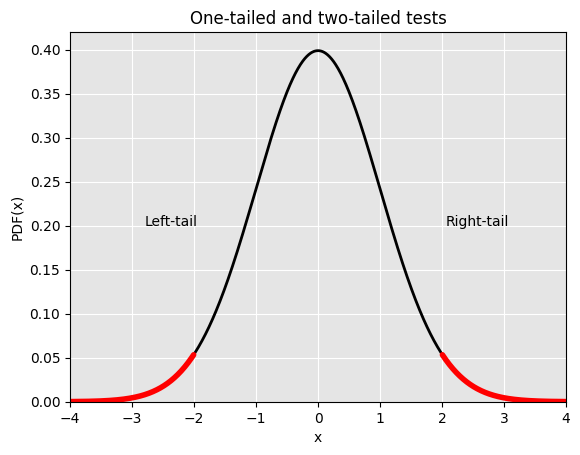

####  **p-values**

**p-values**: probability of obtaining a result, assuming the null hypothesis is true.

- Large p-value, large support for $H_0$
  - Statistic likely **not** in the tail of the *null distribution*
- Small p-value, strong evidence against $H_0$
  - Statistic likely in the tail of the *null distribution*
- "p" in *p-value* → probability
- "small" means "close to zero"

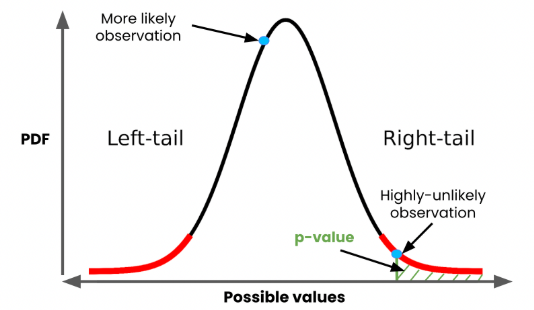


In [241]:
# Create a boolean Series where True indicates respondents who started coding as a child
is_child = stack_overflow["age_first_code_cut"] == "child"

# Set the random seed for reproducibility of random sampling
np.random.seed(42)

# Generate a bootstrap distribution of the proportion of respondents who started coding as a child
# For each iteration, sample with replacement from the 'is_child' Series and calculate the mean proportion
first_code_boot_distn = [
    is_child.sample(frac=1.0, replace=True).mean() for _ in range(1000)
]

In [242]:
from scipy.stats import norm

# Calculate the sample proportion of respondents who started coding as a child
prop_child_samp = (stack_overflow["age_first_code_cut"] == "child").mean()

# Set the hypothesized proportion under the null hypothesis
prop_child_hyp = 0.35

# Estimate the standard error from the bootstrap distribution of proportions
std_error = np.std(first_code_boot_distn, ddof=1)

# Calculate the z-score: standardized difference between sample and hypothesized proportion
z_score = (prop_child_samp - prop_child_hyp) / std_error

# Calculate the p-value for a right-tailed test (probability of observing a z-score this large or larger)
p_value = 1 - norm.cdf(z_score, loc=0, scale=1)

print(p_value)

2.4023022520913706e-05


#### Late shipments 

In [243]:
from scipy.stats import norm

# Calculate the z-score: standardizes the difference between sample and hypothesized proportions
z_score = (late_prop_samp - late_prop_hyp) / std_error

# Calculate the p-value: probability of observing a z-score this large or larger under the null hypothesis (right-tailed test)
p_value = 1 - norm.cdf(z_score)

# Print the p-value; a small value suggests the sample proportion is significantly greater than hypothesized
print(p_value)

0.4609105419487346


## The Significance Level ($\alpha$): Defining the Threshold

The **p-value** quantifies the evidence against the null hypothesis ($H_0$). A small p-value means the observed sample data is very unlikely if the null hypothesis were true. But how small is "small enough" to reject $H_0$?

This cutoff point is the **significance level**, denoted by the Greek letter **$\alpha$ (alpha)**. It represents the threshold for our "beyond a reasonable doubt" criterion.

* **Definition**: The significance level, $\alpha$, is the probability of rejecting the null hypothesis when it is, in fact, true (a Type I error).
* **Common Values**: Typical values for $\alpha$ are 0.1 (10%), 0.05 (5%), and 0.01 (1%). The most widely used standard in many fields is $\alpha = 0.05$.
* **Decision Rule**: The value of $\alpha$ must be chosen *before* conducting the hypothesis test to avoid bias. The decision is then made by a direct comparison:
        * If $p \leq \alpha$, we **reject the null hypothesis**. The result is statistically significant.
        * If $p > \alpha$, we **fail to reject the null hypothesis**. The result is not statistically significant.


### The Relationship Between Confidence Intervals and Significance Tests

Confidence intervals and hypothesis tests are two sides of the same coin; they are different ways of performing statistical inference on the same underlying data. There is a direct duality between them:

A **two-tailed** hypothesis test with a significance level of $\alpha$ is equivalent to checking if the hypothesized parameter value falls **outside** the corresponding $1 - \alpha$ confidence interval.

* If $\alpha = 0.05$, we use a $1 - 0.05 = 0.95$, or **95% confidence interval**.
* **Decision Rule**:
        * If the hypothesized parameter value falls **outside** the 95% confidence interval, we **reject the null hypothesis**.
        * If the hypothesized parameter value falls **inside** the 95% confidence interval, we **fail to reject the null hypothesis**.

This provides a more intuitive, graphical way to interpret the result of a hypothesis test.

### Types of Errors in Hypothesis Testing

Because our decision is based on a sample, not the entire population, we can never be 100% certain about the true state of the world. Our statistical decision can sometimes be wrong. There are two types of errors we can make:

|                       | **True State: $H_0$ is True**         | **True State: $H_A$ is True**         |
|-----------------------|:--------------------------------------:|:--------------------------------------:|
| **Fail to Reject $H_0$** | Correct Decision<br>(True Negative)     | **Type II Error**<br>(False Negative)  |
| **Reject $H_0$**         | **Type I Error**<br>(False Positive)   | Correct Decision<br>(True Positive)    |

- **Type I Error (False Positive)**: Rejecting the null hypothesis when it is actually true. We conclude there is an effect when, in reality, there is none. The probability of making a Type I error is equal to our chosen significance level, $\alpha$.
- **Type II Error (False Negative)**: Failing to reject the null hypothesis when it is actually false. We conclude there is no effect when, in reality, there is one. The probability of a Type II error is denoted by $\beta$ (beta).


### A Complete Example

Let's tie these concepts together with a complete example, from calculating the p-value to making a decision and considering the confidence interval.

```python
import numpy as np
from scipy.stats import norm

# 1. Setup (from previous topics) 
# Assume we have a sample, a hypothesis, and have calculated the necessary statistics.
sample_mean = 119500
hypothesized_mean = 115000
standard_error = 2300
alpha = 0.05 # Our pre-defined significance level

# 2. Perform the Hypothesis Test (p-value approach)
# H0: The true mean is 115000.
# HA: The true mean is not 115000 (a two-tailed test).

# Calculate the z-score
z_score = (sample_mean - hypothesized_mean) / standard_error
# Calculate the two-tailed p-value
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f"Z-score: {z_score:.4f}")
print(f"P-value: {p_value:.4f}")

# Make a decision
if p_value < alpha:
    print(f"Decision: Reject H0, because p ({p_value:.4f}) < alpha ({alpha}). The result is statistically significant.")
else:
    print(f"Decision: Fail to reject H0, because p ({p_value:.4f}) >= alpha ({alpha}).")

# 3. Perform the Hypothesis Test (Confidence Interval approach) 
# For alpha = 0.05, we need a 95% confidence interval.
# We will use the standard error method to construct it.
confidence_level = 1 - alpha # 0.95
lower_quantile = (1 - confidence_level) / 2 # 0.025
upper_quantile = 1 - lower_quantile # 0.975

# Calculate the bounds
lower_bound = norm.ppf(lower_quantile, loc=sample_mean, scale=standard_error)
upper_bound = norm.ppf(upper_quantile, loc=sample_mean, scale=standard_error)

print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

# Make a decision
if not (lower_bound <= hypothesized_mean <= upper_bound):
    print(f"Decision: Reject H0, because the hypothesized mean ({hypothesized_mean}) is outside the confidence interval.")
else:
    print(f"Decision: Fail to reject H0, because the hypothesized mean ({hypothesized_mean}) is inside the confidence interval.")

```

Both approaches lead to the same conclusion. Because our p-value is less than our significance level of 0.05, and equivalently, because the hypothesized mean of 115,000 falls outside our calculated 95% confidence interval, we reject the null hypothesis. We have statistically significant evidence that the true mean is different from 115,000. If we were wrong in this conclusion (a Type I error), it would mean the true mean really was 115,000, and we were misled by an unusually high sample mean.

In [244]:
n = len(stack_overflow)

# Set the significance level for the hypothesis test (probability of Type I error)
alpha = 0.05

# Calculate the sample proportion of respondents who started coding as a child
prop_child_samp = np.mean((stack_overflow["age_first_code_cut"] == "child"))

# Set the hypothesized proportion under the null hypothesis
prop_child_hyp = 0.35

# Estimate the standard error from the bootstrap distribution of proportions
# The standard error quantifies the expected variability of the sample proportion
std_error_null = np.sqrt(prop_child_hyp * (1 - prop_child_hyp) / n)

# Calculate the z-score: standardized difference between sample and hypothesized proportion
# The z-score tells us how many standard errors the observed value is from the null hypothesis
z_score = (prop_child_samp - prop_child_hyp) / std_error_null

# Calculate the p-value for a right-tailed test (probability of observing a z-score this large or larger)
# The p-value quantifies how surprising our result is under the null hypothesis
p_value = 1 - norm.cdf(z_score, loc=0, scale=1)

# Print the p-value; a small value (below alpha) suggests the sample proportion is significantly greater than hypothesized
print(p_value)

1.8200719041461255e-05


Stackoverflow 

In [245]:
# Use np.quantile to compute the 2.5th and 97.5th percentiles of the bootstrap distribution (95% confidence interval)
lower, upper = np.quantile(first_code_boot_distn, [0.025, 0.975])

# Print the lower bound of the confidence interval
print(f"Lower quantile: {lower}")

# Print the upper bound of the confidence interval
print(f"Upper quantile: {upper}")

Lower quantile: 0.3719482529854047
Upper quantile: 0.410437859354268


In [246]:
# Tie to hypothesis: Does CI contain the null value?
if lower > prop_child_hyp:
    print(f"CI excludes {prop_child_hyp}, consistent with rejecting H0 at 5% level.")
elif upper < prop_child_hyp:
    print(f"CI excludes {prop_child_hyp} (below), but note: our test was right-tailed.")
else:
    print(f"CI includes {prop_child_hyp}, consistent with failing to reject H0.")

CI excludes 0.35, consistent with rejecting H0 at 5% level.


Late Shipments

In [247]:
# Calculate a 95% confidence interval from late_shipments_boot_distn using the quantile method, labeling the lower and upper intervals lower and upper.
lower, upper = np.quantile(late_shipments_boot_distn, [0.025, 0.975])

print(f"Lower quantile: {lower}")
print(f"Upper quantile: {upper}")

Lower quantile: 0.046
Upper quantile: 0.076


## The Two-Sample Problem

A common analytical task is to compare a continuous numerical variable across two distinct groups defined by a categorical variable. For example, we might want to know:

  * Is the average salary different for employees who have a certification versus those who do not?
  * Is the average blood pressure lower for a group taking a new drug compared to a group taking a placebo?

This setup, where we compare the means of two independent groups, is the basis for the two-sample t-test.



### Formulating hypotheses for a two-sample test

Let $\mu_1$ denote the population mean of Group 1 and $\mu_2$ that of Group 2.

* **Null hypothesis ($H_0$)** — no difference between population means:  
  $H_0: \mu_1 = \mu_2$  
  or equivalently  
  $H_0: \mu_1 - \mu_2 = 0$

* **Alternative hypothesis ($H_A$)** — actual difference exists (choose tail based on research question):
  * *Two-tailed test* (any difference):  
    $H_A: \mu_1 \neq \mu_2$
  * *Right-tailed test* (Group 1 > Group 2):  
    $H_A: \mu_1 > \mu_2$
  * *Left-tailed test* (Group 1 < Group 2):  
    $H_A: \mu_1 < \mu_2$



### The t‑statistic

The test statistic for comparing two means is the **t‑statistic**. It standardises the difference between the two sample means into a single number, accounting for the variability within each sample. The generic form of a standardised test statistic is

$$
\text{Test Statistic} = \frac{\text{Observed Sample Statistic} \, - \, \text{Hypothesised Population Parameter}}{\text{Standard Error of the Statistic}}
$$

### Two-Sample t-Test Formula

The t-statistic for a two-sample test is calculated as:

$$ t = \frac{(\bar{x}_1 - \bar{x}_2) - (\mu_1 - \mu_2)}{\text{SE}(\bar{x}_1 - \bar{x}_2)} $$

where:
- $\bar{x}_1$ and $\bar{x}_2$ are the sample means
- $\mu_1$ and $\mu_2$ are the population means

The standard error of the difference between two independent means is:

$$ \text{SE}(\bar{x}_1 - \bar{x}_2) = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}} $$

where:
- $s_1$ and $s_2$ are the sample standard deviations
- $n_1$ and $n_2$ are the sample sizes

#### Under the Null Hypothesis ($H_0$)

When assuming $H_0$ is true ($\mu_1 - \mu_2 = 0$), the formula simplifies to:

$$ t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\dfrac{s_1^2}{n_1} + \dfrac{s_2^2}{n_2}}} $$

This t-value measures how many standard errors the observed difference ($\bar{x}_1 - \bar{x}_2$) lies from the hypothesized difference of zero.

### A Complete Calculation in Python

Let's walk through the calculation of the t-statistic for a two-sample problem.

```python
import pandas as pd
import numpy as np

# Create a generic, reproducible dataset
np.random.seed(42)
group1_data = np.random.normal(loc=110, scale=30, size=100)
group2_data = np.random.normal(loc=100, scale=30, size=150)
df = pd.DataFrame({
    'group': ['Group 1'] * 100 + ['Group 2'] * 150,
    'value': np.concatenate([group1_data, group2_data])
})

# Step 1: Calculate Groupwise Summary Statistics 
# Use .groupby() and .agg() to get mean, std, and count for each group
summary_stats = df.groupby('group')['value'].agg(['mean', 'std', 'count'])
print(summary_stats)

# Extract the individual statistics
mean_group1 = summary_stats.loc['Group 1', 'mean']
mean_group2 = summary_stats.loc['Group 2', 'mean']
std_group1 = summary_stats.loc['Group 1', 'std']
std_group2 = summary_stats.loc['Group 2', 'std']
n_group1 = summary_stats.loc['Group 1', 'count']
n_group2 = summary_stats.loc['Group 2', 'count']

# Step 2: Calculate the t-statistic 
# Numerator: Difference in sample means
numerator = mean_group1 - mean_group2

# Denominator: Standard error of the difference
denominator = np.sqrt(
    (std_group1 ** 2 / n_group1) + (std_group2 ** 2 / n_group2)
)

# Final t-statistic
t_statistic = numerator / denominator

print(f"t-statistic: {t_statistic:.4f}")
```

This calculated t-statistic would then be used to find a p-value, allowing us to make a formal conclusion about our hypothesis. A larger absolute t-statistic suggests a greater difference between the groups relative to their internal variability, providing stronger evidence against the null hypothesis.

In [248]:
# Calculate the mean compensation for each group ("adult" and "child") using groupby and mean()
xbar_adult, xbar_child = stack_overflow.groupby("age_first_code_cut")[
    "converted_comp"
].mean()

# Calculate the standard deviation of compensation for each group using groupby and std()
s_adult, s_child = stack_overflow.groupby("age_first_code_cut")["converted_comp"].std()

# Calculate the sample size (count) for each group using groupby and count()
n_adult, n_child = stack_overflow.groupby("age_first_code_cut")[
    "converted_comp"
].count()

#### Two-Sample t-Test Statistic

The test statistic for comparing shipment weights:

$$ t = \frac{\bar{x}_{\text{no}} - \bar{x}_{\text{yes}}}{\sqrt{ \frac{s_{\text{no}}^2}{n_{\text{no}}} + \frac{s_{\text{yes}}^2}{n_{\text{yes}}} }} $$

Where:
- $\bar{x}_{\text{no}}$: Mean weight of on-time shipments
- $\bar{x}_{\text{yes}}$: Mean weight of late shipments
- $s_{\text{no}}$: Standard deviation of on-time shipments
- $s_{\text{yes}}$: Standard deviation of late shipments
- $n_{\text{no}}$: Number of on-time shipments
- $n_{\text{yes}}$: Number of late shipments

### Research Context
While trying to determine why some shipments are late, you may wonder if the weight of shipments that were **on time** is less than the weight of shipments that were **late**. 

The analysis uses:
- `late_shipments` dataset split into:
  - "no" group (`late == "No"`)
  - "yes" group (`late == "Yes"`)
- Weight measurements from `weight_kilograms` variable



In [249]:
# Calculate the numerator: difference in mean compensation between "child" and "adult" groups
numerator = xbar_child - xbar_adult

# Calculate the denominator: standard error of the difference in means
# Formula: sqrt(s_child^2 / n_child + s_adult^2 / n_adult)
denominator = np.sqrt(s_child**2 / n_child + s_adult**2 / n_adult)

# Compute the t-statistic: standardized difference in means
# t = (mean_child - mean_adult) / SE; measures how many standard errors the observed difference is from zero
t_stat = numerator / denominator

# Print the t-statistic; a larger absolute value indicates a more significant difference between groups
print(t_stat)

1.8699313316221844


### Standard error

$$
SE\bigl(\bar{x}_{\text{child}} - \bar{x}_{\text{adult}}\bigr) \approx \sqrt{\frac{s_{\text{child}}^{2}}{n_{\text{child}}} + \frac{s_{\text{adult}}^{2}}{n_{\text{adult}}}}
$$

$s$ is the standard deviation of the variable  
$n$ is the sample size (number of observations/rows in the sample)


#### Null Hypothesis == True
If we assume that the null hypothesis is true, there's a simplification we can make. The null hypothesis assumes that the population means are equal, and their difference is zero, so the population term in the numerator disappears.


If $H_0:\ \mu_{\text{child}}=\mu_{\text{adult}}$ (so $\mu_{\text{child}}-\mu_{\text{adult}}=0$), the t-statistic is

$$
t
=
\frac{(\bar{x}_{\text{child}} - \bar{x}_{\text{adult}}) - (\mu_{\text{child}} - \mu_{\text{adult}})}
{\mathrm{SE}(\bar{x}_{\text{child}} - \bar{x}_{\text{adult}})}
=
\frac{\bar{x}_{\text{child}} - \bar{x}_{\text{adult}}}
{\mathrm{SE}(\bar{x}_{\text{child}} - \bar{x}_{\text{adult}})}.
$$

- $t$: t-statistic  
- $\bar{x}_{\text{child}}$: sample mean of the child group  
- $\bar{x}_{\text{adult}}$: sample mean of the adult group  
- $\mu_{\text{child}},\ \mu_{\text{adult}}$: population means  
- $\mathrm{SE}(\bar{x}_{\text{child}} - \bar{x}_{\text{adult}})$: standard error of the difference in means

In [250]:
late_no, late_yes = (
    late_shipments[late_shipments["late"] == flag] for flag in ("No", "Yes")
)

# Compute the mean and standard deviation of shipment weights for each group using tuple unpacking and generator expressions
xbar_no, xbar_yes = late_shipments.groupby("late")["weight_kilograms"].mean()[
    ["No", "Yes"]
]

s_no, s_yes = late_shipments.groupby("late")["weight_kilograms"].std(ddof=1)[
    ["No", "Yes"]
]

# Get the sample size for each group by counting the number of rows in each DataFrame
n_no, n_yes = len(late_no), len(late_yes)

In [251]:
# Calculate the numerator of the test statistic
# A negative value means on-time shipments are lighter on average
numerator = xbar_no - xbar_yes

# Calculate the denominator (standard error) for independent samples
# Formula: sqrt(s_no^2 / n_no + s_yes^2 / n_yes)
# s_no**2 and s_yes**2 are the sample variances for each group
# n_no and n_yes are the sample sizes for each group
denominator = np.sqrt((s_no**2 / n_no) + (s_yes**2 / n_yes))

# Calculate the t-statistic: standardized difference in means
# t_stat tells us how many standard errors the observed difference is from zero (the null hypothesis)
t_stat = numerator / denominator

print(t_stat)

-2.3936661778766433


Interpretation:
1) A negative t-statistic indicates on-time shipments are lighter than late shipments.
2) The magnitude shows how significant this difference is relative to sample variability.

## The t-distribution: A Family of Curves

While a z-statistic follows the standard normal distribution, a **t-statistic** follows a **t-distribution**. Like the normal distribution, a t-distribution is bell-shaped and centered at zero. However, it has a key difference: **it has fatter tails**.

This means that a t-distribution has more probability in its tails, reflecting the increased uncertainty we have when we use a sample standard deviation (`s`) to estimate a population standard deviation ($\sigma$).

The t-distribution is not a single distribution but a **family of distributions**. The exact shape of a particular t-distribution is defined by a single parameter: the **degrees of freedom (df)**.

  * For a small number of degrees of freedom, the tails are very fat.
  * As the degrees of freedom increase, the t-distribution's tails become thinner, and it converges towards the standard normal distribution. A t-distribution with infinite degrees of freedom is identical to the standard normal distribution.

### Calculating Degrees of Freedom

In statistics, **degrees of freedom** represent the number of independent values in a calculation that are free to vary. For an independent two-sample t-test, the degrees of freedom are calculated based on the sample sizes of the two groups. The standard formula is:

$$df = n_1 + n_2 - 2$$

Where $n\_1$ and $n\_2$ are the sample sizes of Group 1 and Group 2, respectively. The logic is that we start with $n_1 + n_2$ total observations and lose one degree of freedom for each of the two sample means we must estimate from the data.


### Calculating the p-value from a t-statistic

Once you have the t-statistic and degrees of freedom, calculate the p-value using the t-distribution's Cumulative Distribution Function (CDF). The `scipy.stats` library provides `t.cdf()` (analogous to `norm.cdf()` for z-tests).

The calculation depends on the alternative hypothesis:

* **Right-tailed test** ($H_A: \mu_1 > \mu_2$):  
  p-value = area to the *right* of t-statistic  
  ```python
  p_value = 1 - t.cdf(t_stat, df=degrees_of_freedom)
  ```

* **Left-tailed test** ($H_A: \mu_1 < \mu_2$):  
  p-value = area to the *left* of t-statistic  
  ```python
  p_value = t.cdf(t_stat, df=degrees_of_freedom)
  ```

* **Two-tailed test** ($H_A: \mu_1 \neq \mu_2$):  
  p-value = combined area in both tails  
  ```python
  p_value = 2 * (1 - t.cdf(abs(t_stat), df=degrees_of_freedom))
  ```

### A Complete Example

Let's complete the hypothesis test from the previous topic by calculating the p-value from our t-statistic and making a statistical decision.

```python
import pandas as pd
import numpy as np
from scipy.stats import t

# 1. Setup (from previous topic)
# Create a generic, reproducible dataset
np.random.seed(42)
group1_data = np.random.normal(loc=110, scale=30, size=100)
group2_data = np.random.normal(loc=100, scale=30, size=150)
df = pd.DataFrame({
    'group': ['Group 1'] * 100 + ['Group 2'] * 150,
    'value': np.concatenate([group1_data, group2_data])
})

# Calculate groupwise summary statistics
summary_stats = df.groupby('group')['value'].agg(['mean', 'std', 'count'])
mean_group1 = summary_stats.loc['Group 1', 'mean']
mean_group2 = summary_stats.loc['Group 2', 'mean']
std_group1 = summary_stats.loc['Group 1', 'std']
std_group2 = summary_stats.loc['Group 2', 'std']
n_group1 = summary_stats.loc['Group 1', 'count']
n_group2 = summary_stats.loc['Group 2', 'count']

# Calculate the t-statistic
numerator = mean_group1 - mean_group2
denominator = np.sqrt((std_group1 ** 2 / n_group1) + (std_group2 ** 2 / n_group2))
t_statistic = numerator / denominator

# 2. State Hypotheses and Define Test
# H0: The mean of Group 1 is equal to the mean of Group 2 (μ1 = μ2)
# HA: The mean of Group 1 is greater than the mean of Group 2 (μ1 > μ2)
# This is a right-tailed test.
alpha = 0.05 # Significance level

# 3. Calculate Degrees of Freedom
degrees_of_freedom = n_group1 + n_group2 - 2

# 4. Calculate the p-value 
# For a right-tailed test, we calculate the area to the right of our t-statistic.
p_value = 1 - t.cdf(t_statistic, df=degrees_of_freedom)

print(f"t-statistic: {t_statistic:.4f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print(f"P-value: {p_value:.4f}")

# 5. Make a Statistical Decision 
if p_value < alpha:
    print(f"\nDecision: Reject H0, because p ({p_value:.4f}) < alpha ({alpha}).")
else:
    print(f"\nDecision: Fail to reject H0, because p ({p_value:.4f}) >= alpha ({alpha}).")
```

This complete workflow, from stating hypotheses to calculating the t-statistic and degrees of freedom to finally finding the p-value, allows for a rigorous statistical comparison between the means of two groups.

In [252]:
# Calculating p-values: two means from different groups (RECAP)
alpha = 0.1

# Calculate the mean compensation for each group ("adult" and "child") using groupby and mean()
xbar_adult, xbar_child = stack_overflow.groupby("age_first_code_cut")[
    "converted_comp"
].mean()

# Calculate the standard deviation of compensation for each group using groupby and std()
s_adult, s_child = stack_overflow.groupby("age_first_code_cut")["converted_comp"].std()

# Calculate the sample size (count) for each group using groupby and count()
n_adult, n_child = stack_overflow.groupby("age_first_code_cut")[
    "converted_comp"
].count()

# Calculate the numerator: difference in mean compensation between "child" and "adult" groups
numerator = xbar_child - xbar_adult

# Calculate the denominator: standard error of the difference in means
# Formula: sqrt(s_child^2 / n_child + s_adult^2 / n_adult)
denominator = np.sqrt(s_child**2 / n_child + s_adult**2 / n_adult)

# Compute the t-statistic: standardized difference in means
# t = (mean_child - mean_adult) / SE; measures how many standard errors the observed difference is from zero
t_stat = numerator / denominator

# Print the t-statistic; a larger absolute value indicates a more significant difference between groups
print(t_stat)

1.8699313316221844


Continuing the calculation from the RECAP

In [253]:
from scipy.stats import t

# Total number of observations from both groups -2
degrees_of_freedom = n_child + n_adult - 2

# Use t-distribution CDF not normal CDF
p_value = 1 - t.cdf(t_stat, df=degrees_of_freedom)


if p_value < alpha:
    print(
        f"Right-tailed two-sample t-test for mean compensation (H_A: μ_child > μ_adult): p-value = {p_value:.6f} (t = {t_stat:.4f}, df = {degrees_of_freedom})"
    )
    print(
        """
        Therefore, we should reject the null hypothesis in favor of the alternative hypothesis 
        that Stack Overflow data scientists who started coding as children earn more.
        """
    )

Right-tailed two-sample t-test for mean compensation (H_A: μ_child > μ_adult): p-value = 0.030811 (t = 1.8699, df = 2259)

        Therefore, we should reject the null hypothesis in favor of the alternative hypothesis 
        that Stack Overflow data scientists who started coding as children earn more.
        


Moving on to the late_shipment dataset now

In [254]:
# Significance threshold for the hypothesis test
alpha = 0.1

# Split the late_shipments dataset into on-time ("No") and late ("Yes") groups
late_no, late_yes = (
    late_shipments[late_shipments["late"] == flag] for flag in ("No", "Yes")
)

# Group summary: mean weight (kilograms) for on-time and late shipments
xbar_no, xbar_yes = late_shipments.groupby("late")["weight_kilograms"].mean()[
    ["No", "Yes"]
]

# Group summary: sample standard deviations (ddof=1) for each group
s_no, s_yes = late_shipments.groupby("late")["weight_kilograms"].std(ddof=1)[
    ["No", "Yes"]
]

# Sample sizes for each group
n_no, n_yes = len(late_no), len(late_yes)

# Compute the test statistic for the independent two-sample t-test:
# t = (mean_no - mean_yes) / sqrt(s_no^2/n_no + s_yes^2/n_yes)
numerator = xbar_no - xbar_yes
denominator = np.sqrt((s_no**2 / n_no) + (s_yes**2 / n_yes))
t_stat = numerator / denominator

# Degrees of freedom for the independent two-sample t-test (pooled df)
degrees_of_freedom = n_no + n_yes - 2

# Our research question: are on-time shipments lighter than late shipments?
# This is a left-tailed test: H_A: mu_no < mu_yes
p_value = t.cdf(t_stat, df=degrees_of_freedom)

# Report results with context and decisive language
print(
    f"  t = {t_stat:.4f}, df = {degrees_of_freedom}, p-value (left-tailed) = {p_value:.6f}"
)

if p_value < alpha:
    print(
        f"Conclusion: Reject H0 at alpha = {alpha:.2f}.\n"
        f"There is strong evidence that on-time shipments are lighter than late shipments \n"
        f"(p = {p_value:.6f} < {alpha:.2f})."
    )
else:
    print(
        f"Conclusion: Fail to reject H0 at alpha = {alpha:.2f}. \n"
        f"There is insufficient evidence that on-time shipments are lighter than late shipments "
        f"(p = {p_value:.6f} >= {alpha:.2f})."
    )

  t = -2.3937, df = 998, p-value (left-tailed) = 0.008432
Conclusion: Reject H0 at alpha = 0.10.
There is strong evidence that on-time shipments are lighter than late shipments 
(p = 0.008432 < 0.10).


## Independent vs. Paired Samples

It is critical to distinguish between independent and paired samples, as using the wrong test can lead to incorrect conclusions.

  * **Independent Samples**: The observations in one group have no direct relationship to the observations in the other. The groups are mutually exclusive. An example is comparing the test scores of a control group of students to a treatment group of *different* students. An **independent two-sample t-test** is used here.

  * **Paired (or Dependent) Samples**: Each observation in one group is directly linked to a specific observation in the other group. This structure is common in:

      * **Before-and-after studies**: Measuring a subject's weight before and after an intervention.
      * **Matched-pair studies**: Comparing outcomes for subjects who have been matched on key characteristics.
      * **Repeated measures**: Measuring the same subject under two different conditions. The provided example of comparing vote percentages in the *same counties* across two different elections is a classic case of paired data.

Using an independent (unpaired) t-test on paired data is a statistical error. It ignores the valuable information contained in the pairing, which can reduce the statistical power of the test and increase the chances of a false negative (a Type II error).

### The Logic of the Paired t-test: From Two Samples to One

The elegance of the paired t-test is that it simplifies a two-sample problem into a **one-sample problem**. Instead of analyzing two separate groups of data, we analyze a single group of **differences**.

1.  For each pair, calculate the difference between the two measurements.
2.  This creates a single new sample of these difference values.
3.  We then perform a one-sample t-test on this sample of differences.

This transforms the original hypothesis about the two group means into an equivalent hypothesis about the mean of the differences ($\mu_{\text{diff}}$).

  * **Original Hypotheses**: $H_0: \mu_1 - \mu_2 = 0 \quad$ vs. $ \quad H_A: \mu_1 - \mu_2 \neq 0$
  * **Equivalent Paired Hypotheses**: $H_0: \mu_{\text{diff}} = 0 \quad$ vs. $ \quad H_A: \mu_{\text{diff}} \neq 0$


## The Paired t-statistic

Since the problem is reduced to a one-sample test on the differences, we use the one-sample t-statistic formula:

$$
t \;=\; \frac{\bar{x}_{\text{diff}} - \mu_{\text{diff,hypothesized}}}{\operatorname{SE}(\bar{x}_{\text{diff}})}
\;=\;
\frac{\bar{x}_{\text{diff}} - 0}{\dfrac{s_{\text{diff}}}{\sqrt{n_{\text{diff}}}}}
$$

Where:

  * $\bar{x}_{\text{diff}}$ is the mean of the sample differences.
  * $s_{\text{diff}}$ is the standard deviation of the sample differences.
  * $n_{\text{diff}}$ is the number of pairs (i.e., the sample size of the differences).

The degrees of freedom (df) for this test are:

$$
df = n_{\text{diff}} - 1
$$


### Implementation in Python

We can perform a paired t-test in two ways: by manually calculating the differences and running a one-sample test, or by using a function that handles the pairing directly.

#### The Manual Approach (as a One-Sample t-test)

This approach makes the underlying logic of the test explicit.

```python
import pandas as pd
import numpy as np
import pingouin
from scipy.stats import t

# 1. Create a generic, reproducible paired dataset
np.random.seed(42)
before_scores = np.random.normal(loc=100, scale=15, size=50)
# Create 'after' scores that are slightly higher on average
after_scores = before_scores + np.random.normal(loc=5, scale=5, size=50)
df = pd.DataFrame({'before': before_scores, 'after': after_scores})

# 2. Calculate the 'difference' column
df['difference'] = df['after'] - df['before']

# 3. Perform a one-sample t-test on the differences against a mean of 0
# This is equivalent to pingouin.ttest(x=df['difference'], y=0)
xbar_diff = df['difference'].mean()
s_diff = df['difference'].std()
n_diff = len(df['difference'])
df_diff = n_diff - 1

# Calculate the t-statistic manually
t_statistic_manual = (xbar_diff - 0) / (s_diff / np.sqrt(n_diff))
# Calculate the p-value
p_value_manual = 1 - t.cdf(t_statistic_manual, df=df_diff) # for a right-tailed test

print(f"Mean Difference: {xbar_diff:.4f}")
print(f"t-statistic: {t_statistic_manual:.4f}")
print(f"p-value: {p_value_manual:.8f}")
```

#### The Direct Approach (Using `pingouin`)

The `pingouin.ttest()` function can perform the entire operation directly by setting the `paired=True` argument. This is the more common and convenient approach.

```python
# Use pingouin.ttest with paired=True
# We test HA: after > before, which is a 'greater' alternative.
ttest_results = pingouin.ttest(
    x=df['after'], 
    y=df['before'],
    paired=True,
    alternative='greater'
)

print(ttest_results)
```

The t-statistic and p-value from the direct `pingouin` function are identical to our manual one-sample test on the differences, confirming that both methods are performing the same underlying calculation. This streamlined approach correctly accounts for the paired nature of the data to produce a more powerful and accurate statistical test.

In [255]:
url = "https://assets.datacamp.com/production/repositories/5982/datasets/7e3351ff263f77755c046c79d5ff855f4de3307e/repub_votes_potus_08_12.feather"
repub_votes = pd.read_feather(url)
repub_votes.head()

,state,county,repub_percent_08,repub_percent_12
0,Alabama,Hale,38.957877,37.139882
1,Arkansas,Nevada,56.726272,58.983452
2,California,Lake,38.896719,39.331367
3,California,Ventura,42.923190,45.250693
4,Colorado,Lincoln,74.522569,73.764757


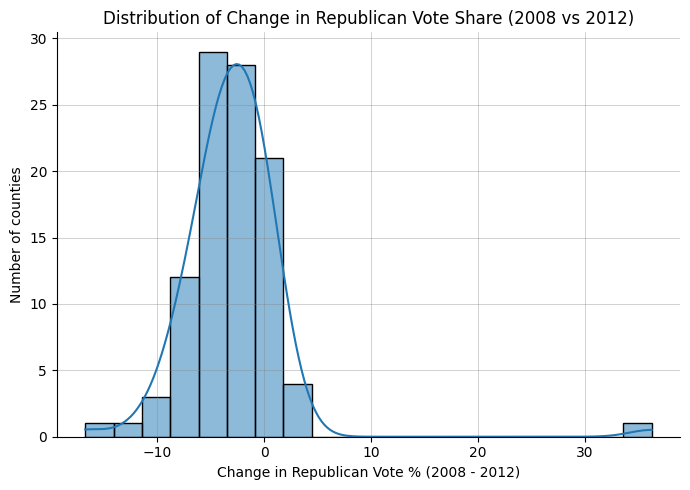

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

repub_votes["diff"] = repub_votes["repub_percent_08"] - repub_votes["repub_percent_12"]

fig, ax = plt.subplots(figsize=(7, 5))

# Histogram with kernel density estimate
sns.histplot(
    repub_votes["diff"], bins=20, kde=True, color="C0", edgecolor="black", ax=ax
)

# Labels, title and styling
ax.set_xlabel("Change in Republican Vote % (2008 - 2012)")
ax.set_ylabel("Number of counties")
ax.set_title("Distribution of Change in Republican Vote Share (2008 vs 2012)")

sns.despine()
ax.grid(True, alpha=0.5, linewidth=0.5, color="grey")

plt.tight_layout()
plt.show()

In [257]:
# import the t-distribution object from scipy.stats to compute CDF and other t-based functions
from scipy.stats import t

# set the significance level (alpha) — probability of type I error; choose before testing
alpha = 0.5

# compute the sample mean of the paired differences (mean change in Republican vote share)
xbar_diff = repub_votes["diff"].mean()

# determine the number of paired observations (sample size)
n_diff = len(repub_votes)

# compute the sample standard deviation of the differences (estimator of variability)
s_diff = repub_votes["diff"].std()

# compute the one-sample t-statistic:
# numerator = observed mean difference - hypothesized mean difference (0 here),
# denominator = estimated standard error = s_diff / sqrt(n)
t_stat = (xbar_diff - 0) / np.sqrt(s_diff**2 / n_diff)

# degrees of freedom for a one-sample (paired) t-test is n - 1
degrees_of_freedom = n_diff - 1

# calculate the left-tailed p-value using the t-distribution CDF:
# p = P(T <= t_stat | H0) for the t random variable with specified df
p_value = t.cdf(t_stat, df=degrees_of_freedom)

# decision rule: if p-value is less than alpha, reject H0 in favor of the left-tailed alternative
if p_value < alpha:
    # report rejection of the null hypothesis and provide test statistics and p-value
    print(
        f"Conclusion: Reject H0 at alpha = {alpha:.2f}.\n"
        f"Evidence suggests the mean change in Republican vote share (2008 − 2012) is less than 0.\n"
        f"Mean change = {xbar_diff:.4f}, t = {t_stat:.4f}, df = {degrees_of_freedom}, p (left-tailed) = {p_value:.2e}."
    )
else:
    # report failure to reject the null hypothesis and provide test statistics and p-value
    print(
        f"Conclusion: Fail to reject H0 at alpha = {alpha:.2f}.\n"
        f"There is insufficient evidence that the mean change in Republican vote share (2008 − 2012) is less than 0.\n"
        f"Mean change = {xbar_diff:.4f}, t = {t_stat:.4f}, df = {degrees_of_freedom}, p (left-tailed) = {p_value:.2e}."
    )

Conclusion: Reject H0 at alpha = 0.50.
Evidence suggests the mean change in Republican vote share (2008 − 2012) is less than 0.
Mean change = -2.8771, t = -5.6010, df = 99, p (left-tailed) = 9.57e-08.


In [258]:
# pingouin.ttest computes t-statistic, p-value, degrees of freedom and effect sizes for one-sample/paired/two-sample tests.
from pingouin import ttest

# Perform a one-sample t-test on the 'diff' column vs. 0.
# H0: μ_diff = 0; alternative='less' specifies a left-tailed test (HA: μ_diff < 0).
repub_ttest = ttest(x=repub_votes["diff"], y=0, alternative="less")

# Display the pingouin result table (contains t, dof, tail, p-val, CI, and effect size estimates).
display(repub_ttest)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.601043,99,less,9.572537e-08,"[-inf, -2.02]",0.560104,1.323e+05,0.999955


Variation for a ttest with paired=True

In [259]:
from pingouin import ttest

# It returns a result table with t, degrees of freedom, tail, p-value, CI, and effect sizes.
# Syntax: ttest(x=..., y=..., paired=True, alternative='less') where alternative='less' sets a left-tailed test (HA: mean_08 < mean_12).
repub_ttest_paired = ttest(
    x=repub_votes["repub_percent_08"],
    y=repub_votes["repub_percent_12"],
    paired=True,
    alternative="less",
)

# Display the pingouin result object (table). For a left-tailed test the p-value is P(T <= t);
display(repub_ttest_paired)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.601043,99,less,9.572537e-08,"[-inf, -2.02]",0.217364,1.323e+05,0.696338


In [260]:
url = "https://assets.datacamp.com/production/repositories/5982/datasets/4ab6431d773d1fe659ac120b4b49a1b525a76712/dem_votes_potus_12_16.feather"
sample_dem_data = pd.read_feather(url)
sample_dem_data.head()

,state,county,dem_percent_12,dem_percent_16
0,Alabama,Bullock,76.305900,74.946921
1,Alabama,Chilton,19.453671,15.847352
2,Alabama,Clay,26.673672,18.674517
3,Alabama,Cullman,14.661752,10.028252
4,Alabama,Escambia,36.915731,31.020546


In [261]:
# Create a new column 'diff' that stores the difference in Democratic vote percentage between 2012 and 2016 for each county.
sample_dem_data["diff"] = (
    sample_dem_data["dem_percent_12"] - sample_dem_data["dem_percent_16"]
)

# Calculate the mean of the 'diff' column; this represents the average change in Democratic vote share across all counties.
xbar_diff = sample_dem_data["diff"].mean()

# Calculate the standard deviation of the 'diff' column; this measures the variability in the change of Democratic vote share.
s_diff = sample_dem_data["diff"].std()

# Print the standard deviation to understand how much the change in vote share varies from county to county.
print(s_diff)

5.040139140132317


In [262]:
sample_dem_data.head()

,state,county,dem_percent_12,dem_percent_16,diff
0,Alabama,Bullock,76.305900,74.946921,1.358979
1,Alabama,Chilton,19.453671,15.847352,3.606319
2,Alabama,Clay,26.673672,18.674517,7.999155
3,Alabama,Cullman,14.661752,10.028252,4.633500
4,Alabama,Escambia,36.915731,31.020546,5.895185


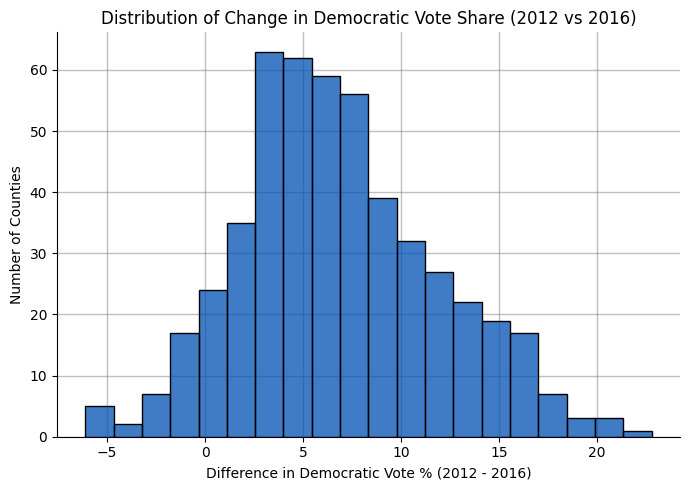

In [263]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plot a histogram of the 'diff' column (change in Democratic vote %) with 20 bins
sns.histplot(
    sample_dem_data["diff"], ax=ax, bins=20, color="#0050B3", edgecolor="black"
)

sns.despine()

ax.set(
    xlabel="Difference in Democratic Vote % (2012 - 2016)",
    ylabel="Number of Counties",
    title="Distribution of Change in Democratic Vote Share (2012 vs 2016)",
)

ax.grid(True, alpha=0.5, linewidth=1, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### Using ttest()
Manually calculating test statistics and transforming them with a CDF to get a p-value is a lot of effort to compare two sample means. The comparison of two sample means is called a t-test, and the `pingouin` Python package has a `.ttest()` method to accomplish it. This method provides some flexibility in how you perform the test.

As in the previous exercise, you'll explore the difference between the proportion of county-level votes for the Democratic candidate in 2012 and 2016 to identify if the difference is significant. The hypotheses are as follows:

$H_0$: The proportion of democratic votes in 2012 and 2016 were the same. <br>
$H_A$: The proportion of democratic votes in 2012 and 2016 were different.

In [264]:
import pingouin

# Perform a one-sample t-test on the 'diff' column to test if the mean difference is significantly different from zero
# This tests the null hypothesis that the average change in Democratic vote share is zero (no change between 2012 and 2016)
# The alternative="two-sided" specifies a two-tailed test: we are interested in any difference, not just an increase or decrease
test_results = pingouin.ttest(
    x=sample_dem_data["diff"],  # The observed differences in vote share
    y=0,  # The hypothesized mean difference under the null hypothesis
    alternative="two-sided",  # Two-sided test: checks for any significant change
)

# Perform a paired t-test comparing the Democratic vote percentages in 2012 and 2016 for each county
# This tests whether the mean vote share in 2012 is significantly different from that in 2016, accounting for the paired nature of the data
# The paired t-test is appropriate because each county provides both a 2012 and a 2016 value (dependent samples)
paired_test_results = pingouin.ttest(
    x=sample_dem_data["dem_percent_12"],  # Democratic vote percentage in 2012
    y=sample_dem_data["dem_percent_16"],  # Democratic vote percentage in 2016
    paired=True,
    alternative="two-sided",  # Two-sided test: checks for any significant change
)

display(paired_test_results)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,30.298384,499,two-sided,3.600634e-115,"[6.39, 7.27]",0.454202,2.246e+111,1.0


## The Problem: Comparing Multiple Groups

While a t-test is the appropriate tool for comparing the means of two groups, it is not suitable for comparing three or more groups simultaneously. Performing multiple t-tests on all possible pairs of groups (e.g., A vs. B, A vs. C, B vs. C) on the same data dramatically increases the probability of committing a **Type I error** (a false positive). Each test has an $\\alpha$ chance of being wrong, and these chances accumulate as you perform more tests.

The correct approach is a two-step process: first, use an omnibus test (ANOVA) to see if *any* difference exists, and second, if a difference is found, use adjusted pairwise tests to find out where it is.


### Analysis of Variance (ANOVA)

**ANOVA** is a statistical test that determines whether there are any statistically significant differences between the means of three or more independent groups. It works by comparing the amount of variation **between** the different groups to the amount of variation **within** each group.

#### Hypotheses for ANOVA

  * **Null Hypothesis ($H_0$)**: The population means of all groups are equal.
    $$H_0: \mu_1 = \mu_2 = \dots = \mu_k$$
  * **Alternative Hypothesis ($H_A$)**: At least one group mean is different from the others.

The ANOVA test is an **omnibus test**. A significant result (a small p-value) tells you that there is a difference *somewhere* among the groups, but it does not tell you which specific groups are different from each other.

#### ANOVA in Python with `pingouin`

The `pingouin` library provides a user-friendly interface for conducting statistical tests. The `pingouin.anova()` function is straightforward to use. You must first install the library: `pip install pingouin`.

```python
import pandas as pd
import numpy as np
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt

# Create a generic, reproducible dataset with multiple groups
np.random.seed(42)
group_means = {'Group A': 50, 'Group B': 55, 'Group C': 50}
df = pd.DataFrame({
    'group': np.random.choice(list(group_means.keys()), 200),
    'value': 0.0 # Placeholder
})
df['value'] = df['group'].apply(lambda g: np.random.normal(loc=group_means[g], scale=5))

# Visualize the group distributions
sns.boxplot(x='group', y='value', data=df)
plt.title('Value Distribution by Group')
plt.show()

# Perform the ANOVA test
# dv: dependent variable (numeric)
# between: the grouping variable (categorical)
anova_results = pingouin.anova(data=df, dv='value', between='group')
print(anova_results)
```

To interpret the result, we look at the p-value (`p-unc`). If `p-unc < α` (our chosen significance level, e.g., 0.05), we reject the null hypothesis and conclude that at least one group mean is different.


### Pinpointing the Difference: Pairwise Tests with P-Value Adjustment

If the ANOVA test is significant, we proceed to the second step: **pairwise t-tests** to compare each group against every other group.

#### The Problem of Multiple Comparisons

As mentioned, running many t-tests inflates the Type I error rate. To counteract this, we must apply a **p-value adjustment**. These methods modify the raw p-values from each t-test to control the overall false positive rate for the entire family of tests.

#### Pairwise Tests with Bonferroni Correction

The **Bonferroni correction** is one of the simplest and most common adjustment methods. It mitigates the issue of multiple comparisons by multiplying each individual p-value by the number of tests being performed. This makes it "harder" for any single test to be declared significant, thereby controlling the overall error rate.

The `pingouin.pairwise_tests()` function can perform this entire process automatically.

```python
# Perform pairwise t-tests with Bonferroni correction 
# padjust='bonf' applies the correction
pairwise_results = pingouin.pairwise_tests(
    data=df,
    dv='value',
    between='group',
    padjust='bonf' # Specify the p-value adjustment method
)

# We are interested in the 'p-corr' (corrected p-value) column
print(pairwise_results[['A', 'B', 'p-unc', 'p-corr']])
```

**Interpretation**:
You examine the **`p-corr`** (corrected p-value) column. If a `p-corr` for a specific pair of groups (e.g., 'Group A' vs. 'Group B') is less than your significance level $\\alpha$, you can conclude that there is a statistically significant difference between the means of those two specific groups. `pingouin` offers several other adjustment methods via the `padjust` argument, such as `'holm'` or `'fdr_bh'`, which are often less conservative than the Bonferroni correction.

In [265]:
stack_overflow["job_sat"].value_counts()

job_sat
Very satisfied           879
Slightly satisfied       680
Slightly dissatisfied    342
Neither                  201
Very dissatisfied        159
Name: count, dtype: int64

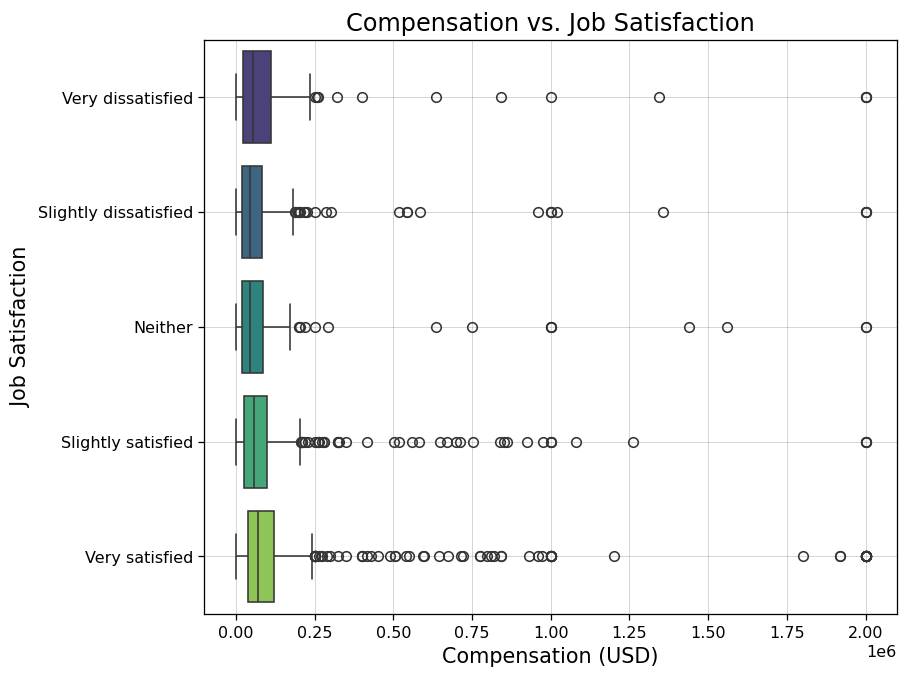

In [266]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=115)

with sns.axes_style("darkgrid", {"axes.facecolor": ".7"}):
    sns.boxplot(
        x="converted_comp",
        y="job_sat",
        data=stack_overflow,
        ax=ax,
        hue="job_sat",
        palette="viridis",
    )

ax.set_xlabel("Compensation (USD)", fontsize=13, fontname="DejaVu Sans")
ax.set_ylabel("Job Satisfaction", fontsize=13, fontname="DejaVu Sans")
ax.set_title("Compensation vs. Job Satisfaction", fontsize=15, fontname="DejaVu Sans")

ax.grid(True, alpha=0.5, linewidth=0.4, color="grey")
plt.tight_layout()
plt.show()

In [267]:
from pingouin import anova

# Set the significance level (alpha) for the hypothesis test: probability of a Type I error (rejecting H0 when true)
alpha = 0.2

# Run a one-way ANOVA comparing mean 'converted_comp' across 'job_sat' groups;
# returns an ANOVA table (F-statistic, degrees of freedom, p-value) used to test H0: all group means equal
anova_test = anova(data=stack_overflow, dv="converted_comp", between="job_sat")

display(anova_test)

,Source,ddof1,ddof2,F,p-unc,np2
0,job_sat,4,2256,4.480485,0.001315,0.007882


The `pingouin.pairwise_tests()` function performs pairwise statistical comparisons between groups.<br>
The `between` argument specifies the grouping variable, and `padjust="bonf"` applies Bonferroni correction for multiple comparisons.<br>
The output includes test statistics, raw and corrected p-values, and a reject column indicating significance at the default `alpha=0.05`.<br>
Statistically, this helps identify which job satisfaction groups differ significantly in compensation after adjusting for multiple testing.<br>

### Available P-Value Adjustment Methods

The `padjust` parameter offers several methods for controlling Type I error in multiple comparisons:

| Method | Description |
|--------|-------------|
| `'none'` | No correction (default) - uses raw p-values |
| `'bonf'` | One-step Bonferroni correction - most conservative |
| `'sidak'` | One-step Šidák correction - slightly less conservative than Bonferroni |
| `'holm'` | Step-down Holm-Bonferroni method - less conservative than Bonferroni |
| `'fdr_bh'` | Benjamini-Hochberg False Discovery Rate correction |
| `'fdr_by'` | Benjamini-Yekutieli False Discovery Rate correction |

**Recommendation**: Use `'bonf'` for strict control of family-wise error rate, or `'fdr_bh'` for better power while controlling false discovery rate.


In [268]:
from pingouin import pairwise_tests

# Execute pairwise comparisons of 'converted_comp' across levels of 'job_sat'.
# Arguments: data=DataFrame, dv=dependent variable name, between=grouping column, padjust='none' returns raw (unadjusted) p-values.
anova_pairwise = pairwise_tests(
    data=stack_overflow, dv="converted_comp", between="job_sat", padjust="bonf"
)

display(anova_pairwise)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,job_sat,Very dissatisfied,Slightly dissatisfied,False,True,1.129951,247.570187,two-sided,0.259590,1.000000,bonf,0.197,0.119131
1,job_sat,Very dissatisfied,Neither,False,True,0.545948,321.165726,two-sided,0.585481,1.000000,bonf,0.135,0.058537
2,job_sat,Very dissatisfied,Slightly satisfied,False,True,1.243665,187.153329,two-sided,0.215179,1.000000,bonf,0.208,0.145624
3,job_sat,Very dissatisfied,Very satisfied,False,True,-0.747379,221.666205,two-sided,0.455627,1.000000,bonf,0.126,-0.063479
4,job_sat,Slightly dissatisfied,Neither,False,True,-0.602209,367.730081,two-sided,0.547406,1.000000,bonf,0.118,-0.055707
5,job_sat,Slightly dissatisfied,Slightly satisfied,False,True,0.038264,569.926329,two-sided,0.969491,1.000000,bonf,0.074,0.002719
6,job_sat,Slightly dissatisfied,Very satisfied,False,True,-3.076222,821.303063,two-sided,0.002166,0.021659,bonf,7.43,-0.173247
7,job_sat,Neither,Slightly satisfied,False,True,0.700752,258.204546,two-sided,0.484088,1.000000,bonf,0.114,0.068513
8,job_sat,Neither,Very satisfied,False,True,-1.662901,328.326639,two-sided,0.097286,0.972864,bonf,0.337,-0.120115
9,job_sat,Slightly satisfied,Very satisfied,False,True,-4.009935,1478.622799,two-sided,0.000064,0.000638,bonf,158.564,-0.192931


In [269]:
# Boolean-index the pingouin pairwise_tests DataFrame to keep rows where the adjusted p-value ('p-corr') is less than alpha.
lower_values = anova_pairwise[anova_pairwise["p-corr"] < alpha]

# Render the filtered DataFrame in the notebook (Jupyter will display it as a table)
display(lower_values)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
6,job_sat,Slightly dissatisfied,Very satisfied,False,True,-3.076222,821.303063,two-sided,0.002166,0.021659,bonf,7.43,-0.173247
9,job_sat,Slightly satisfied,Very satisfied,False,True,-4.009935,1478.622799,two-sided,0.000064,0.000638,bonf,158.564,-0.192931


This block fits an ordinary least squares (OLS) regression model to test if compensation differs by job satisfaction group.<br>
The formula `"converted_comp ~ job_sat"` models compensation as a function of job satisfaction.<br>
`sm.stats.anova_lm()` performs an ANOVA (analysis of variance) to compare group means, outputting F-statistic and p-value.<br>
Statistically, this tests the null hypothesis that all job satisfaction groups have the same mean compensation.<br>
If the `p-value` for `job_sat` is below the chosen alpha (here, 0.2), we reject the null and conclude at least one group differs.<br>

In [270]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set the significance level (alpha) for the ANOVA test; this is the threshold for statistical significance
alpha = 0.2

# Fit an Ordinary Least Squares (OLS) regression model with compensation as the dependent variable and job satisfaction as the categorical predictor
model = ols(formula="converted_comp ~ job_sat", data=stack_overflow).fit()

# Perform an ANOVA (Analysis of Variance) on the fitted model to test if mean compensation differs by job satisfaction group
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA results, which show whether there is a statistically significant difference in compensation between job satisfaction groups
display(anova_table)

,sum_sq,df,F,PR(>F)
job_sat,1.256118e+12,4.0,4.480485,0.001315
Residual,1.581191e+14,2256.0,NaN,NaN


This block uses statsmodels' MultiComparison to perform pairwise t-tests between all job satisfaction groups for compensation.<br>
The `.allpairtest()` method applies t-tests for each pair, with Bonferroni correction for multiple comparisons.<br>
The result is a `SimpleTable`, which is converted to a pandas `DataFrame` for easier viewing.<br>
Statistically, this identifies which job satisfaction groups differ significantly in compensation, controlling for family-wise error rate.

In [271]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison

# Create a MultiComparison object to compare compensation across job satisfaction groups
# This sets up all possible pairwise comparisons between job satisfaction categories for compensation
mc = MultiComparison(stack_overflow["converted_comp"], stack_overflow["job_sat"])

# Perform all pairwise t-tests between job satisfaction groups, using Bonferroni correction for multiple comparisons
# The Bonferroni method adjusts p-values to control the family-wise error rate when making many comparisons
result = mc.allpairtest(sm.stats.ttest_ind, method="bonf")

# Extract the summary table (SimpleTable object) from the result tuple
summary_table = result[0]  # SimpleTable object

# Convert the summary table to a pandas DataFrame for easier inspection and further analysis
anova_like_table = pd.DataFrame(summary_table.data[1:], columns=summary_table.data[0])

display(anova_like_table)

,group1,group2,stat,pval,pval_corr,reject
0,Neither,Slightly dissatisfied,0.6277,0.5305,1.0000,False
1,Neither,Slightly satisfied,0.8541,0.3933,1.0000,False
2,Neither,Very dissatisfied,-0.5527,0.5808,1.0000,False
3,Neither,Very satisfied,-1.5374,0.1245,1.0000,False
4,Slightly dissatisfied,Slightly satisfied,0.0410,0.9673,1.0000,False
5,Slightly dissatisfied,Very dissatisfied,-1.2430,0.2145,1.0000,False
6,Slightly dissatisfied,Very satisfied,-2.7201,0.0066,0.0662,False
7,Slightly satisfied,Very dissatisfied,-1.6546,0.0984,0.9838,False
8,Slightly satisfied,Very satisfied,-3.7795,0.0002,0.0016,True
9,Very dissatisfied,Very satisfied,-0.7371,0.4612,1.0000,False


In [272]:
# Group the late_shipments DataFrame by the 'shipment_mode' column and calculate the mean of 'pack_price' for each group.
# This gives the average pack price for each shipment mode, helping us compare central tendencies across categories.
xbar_pack_by_mode = late_shipments.groupby("shipment_mode")["pack_price"].mean()

# Group the late_shipments DataFrame by 'shipment_mode' and calculate the standard deviation of 'pack_price' for each group.
# The standard deviation measures the spread or variability of pack prices within each shipment mode group.
s_pack_by_mode = late_shipments.groupby("shipment_mode")["pack_price"].std()

display(s_pack_by_mode)

shipment_mode
Air            48.932861
Air Charter     0.992969
Ocean           5.303047
Name: pack_price, dtype: float64

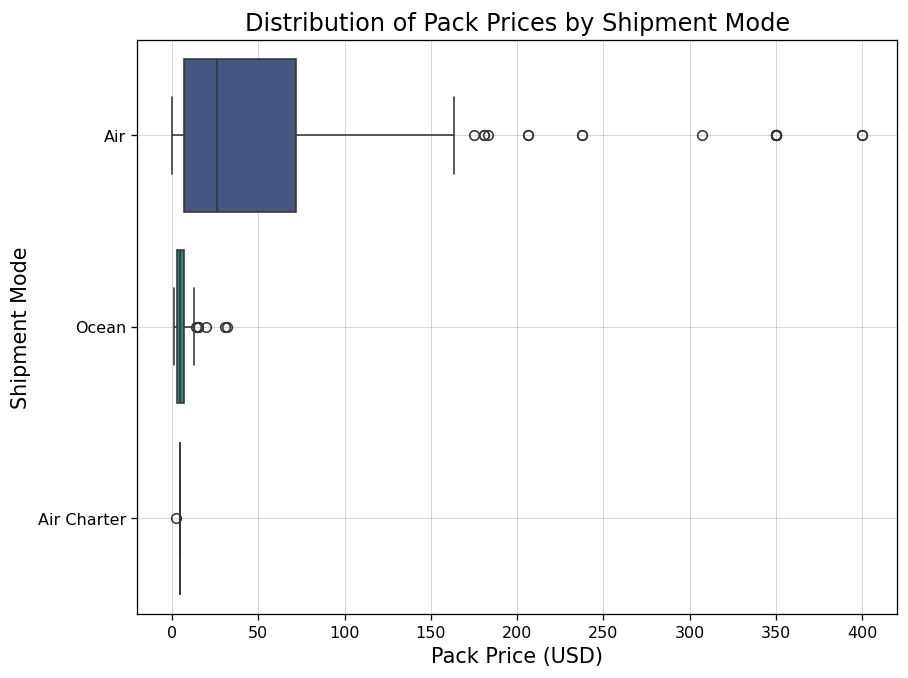

In [273]:
# Create a boxplot from late_shipments with "pack_price" as x and "shipment_mode" as y.
fig, ax = plt.subplots(figsize=(8, 6), dpi=115)

with sns.axes_style("darkgrid", {"axes.facecolor": ".7"}):
    sns.boxplot(
        x="pack_price",
        y="shipment_mode",
        data=late_shipments,
        ax=ax,
        palette="viridis",
        hue="shipment_mode",
    )

ax.set_xlabel("Pack Price (USD)", fontsize=13, fontname="DejaVu Sans")
ax.set_ylabel("Shipment Mode", fontsize=13, fontname="DejaVu Sans")
ax.set_title(
    "Distribution of Pack Prices by Shipment Mode",
    fontsize=15,
    fontname="DejaVu Sans",
)
ax.grid(True, alpha=0.5, linewidth=0.4, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### Conducting an ANOVA test
The box plots made it look like the distribution of pack price was different for each of the three shipment modes. However, it didn't tell us whether the mean pack price was different in each category. To determine that, we can use an ANOVA test. The null and alternative hypotheses can be written as follows.

$H_0$: Pack prices for every category of shipment mode are the same.<br>
$H_A$: Pack prices for some categories of shipment mode are different.


Use a significance level of 0.1.

In [274]:
# Run an ANOVA (Analysis of Variance) to test if the mean pack price differs across shipment modes
# This tests the null hypothesis that all shipment_mode groups have the same mean pack_price
anova_results = pingouin.anova(
    # DataFrame containing the data to analyze
    data=late_shipments,
    # Dependent variable: the numeric variable whose means are compared
    dv="pack_price",
    # Categorical variable defining the groups to compare
    between="shipment_mode",
)

# A small p-value (below alpha) indicates at least one group mean is significantly different
print(anova_results)

          Source  ddof1  ddof2        F         p-unc       np2
0  shipment_mode      2    997  21.8646  5.089479e-10  0.042018


In [275]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit an Ordinary Least Squares (OLS) regression model
# This models 'pack_price' as a function of the categorical variable 'shipment_mode'
# Statistically, this is equivalent to comparing the mean pack price across shipment modes (ANOVA)
model = ols(formula="pack_price ~ shipment_mode", data=late_shipments).fit()

# Perform an ANOVA (Analysis of Variance) on the fitted model
# This tests the null hypothesis that all shipment_mode groups have the same mean pack_price
# The output includes the F-statistic and associated p-value for the group variable
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA results table
# If the p-value for 'shipment_mode' is below your chosen alpha, you reject the null hypothesis
print(anova_table)

                     sum_sq     df        F        PR(>F)
shipment_mode  9.515185e+04    2.0  21.8646  5.089479e-10
Residual       2.169406e+06  997.0      NaN           NaN


In [276]:
# Perform pairwise t-tests to compare the mean pack price between each pair of shipment modes in the late_shipments dataset
pingouin.pairwise_tests(
    # DataFrame containing the data to analyze
    data=late_shipments,
    # Dependent variable: the numeric variable whose means are compared
    dv="pack_price",
    # Categorical variable defining the groups to compare
    between="shipment_mode",
    # No p-value adjustment: each test's p-value is reported as-is (risk of inflated Type I error if many comparisons)
    padjust=None,
)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,shipment_mode,Air,Air Charter,False,True,21.179625,600.685682,two-sided,8.748346e-75,5.809e+76,0.726592
1,shipment_mode,Air,Ocean,False,True,19.335760,986.979785,two-sided,6.934555e-71,1.129e+67,0.711119
2,shipment_mode,Air Charter,Ocean,False,True,-3.170654,35.615026,two-sided,3.123012e-03,15.277,-0.423775


In [277]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison

# Set up a MultiComparison object to compare pack prices across shipment modes
# This object enables all possible pairwise comparisons between the categories in 'shipment_mode'
mc = MultiComparison(late_shipments["pack_price"], late_shipments["shipment_mode"])

# Perform all pairwise t-tests between shipment modes, using Bonferroni correction to control for multiple comparisons
# The Bonferroni method adjusts p-values to reduce the risk of Type I error when making many comparisons
result = mc.allpairtest(sm.stats.ttest_ind, method="bonf")

# Extract the summary table (SimpleTable object) containing the results of all pairwise tests
summary_table = result[0]  # SimpleTable object

# Convert the summary table to a pandas DataFrame for easier inspection and further analysis
anova_like_table = pd.DataFrame(summary_table.data[1:], columns=summary_table.data[0])

display(anova_like_table)

,group1,group2,stat,pval,pval_corr,reject
0,Air,Air Charter,1.7754,0.0762,0.2285,False
1,Air,Ocean,6.3736,0.0000,0.0000,True
2,Air Charter,Ocean,-1.0126,0.3139,0.9417,False


## From Bootstrapping to a Direct Formula

Previously, we determined the significance of a point estimate by a four-step process:

1.  Generate a bootstrap distribution to approximate the sampling distribution.
2.  Calculate the standard error as the standard deviation of the bootstrap distribution.
3.  Compute a standardized test statistic (z-score) using this standard error.
4.  Calculate a p-value from the test statistic to make a decision.

For tests involving proportions, there is a more direct, analytical method that bypasses the need for the computationally intensive bootstrap simulation. This method allows us to calculate the standard error and the z-statistic directly from a known formula.

### The Standardized Test Statistic for Proportions

The general formula for a standardized test statistic is:

$$z = \frac{\text{Sample Statistic} - \text{Hypothesized Parameter}}{SE(\text{Sample Statistic})}$$

For a one-sample test of a proportion, the specific terms are:

  * **Sample Statistic**: $\hat{p}$, the observed sample proportion.
  * **Hypothesized Parameter**: $p_0$, the population proportion assumed under the null hypothesis.
  * **Standard Error**: $SE(\hat{p})$, the standard error of the sample proportion.
  Assuming the null hypothesis is true ($H_0: p = p_0$), the formula becomes:

$$z = \frac{\hat{p} - p_0}{SE(\hat{p})}$$

### A Simplified Standard Error

The key to bypassing the bootstrap is having a direct formula for the standard error. The logic of hypothesis testing requires us to assume the null hypothesis is true. Under this assumption, our best guess for the true population proportion is the hypothesized value, $p_0$. Therefore, we use $p_0$ to calculate the standard error.

The standard error for a sample proportion, under the null hypothesis, is:

$$SE(\hat{p}) = \sqrt{\frac{p_0(1-p_0)}{n}}$$

By substituting this simplified standard error back into the z-statistic formula, we arrive at the final test statistic, which can be calculated without any simulation:

$$z = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}$$

This powerful formula depends only on the sample proportion ($\hat{p}$), the sample size (`n`), and the hypothesized proportion ($p_0$).

### Why a z-test and not a t-test?

We use a **t-test** when we must estimate a population standard deviation ($\sigma$) from our sample standard deviation (`s`). This estimation introduces extra uncertainty, which is accounted for by the "fatter tails" of the t-distribution.

For a proportion test, the situation is different. The variability of a proportion is intrinsically linked to its value. Under the null hypothesis, the standard error is *fully determined* by the hypothesized proportion ($p_0$) and the sample size (`n`). We are not estimating a separate standard deviation parameter from the sample. Since this extra source of uncertainty is absent, the z-distribution is appropriate.


### A Complete Example: One-Sample Proportion Test

Let's conduct a complete one-sample proportion test using this direct analytical method.

**Scenario**: A company claims that 25% of its website visitors make a purchase. We take a sample of 1000 visitors and find that 280 of them made a purchase. Is there significant evidence to suggest the true proportion is different from 25%?

```python
import numpy as np
from scipy.stats import norm

# 1. State Hypotheses and Define Parameters 
# H0: The true proportion of purchasing visitors is 0.25. (p = 0.25)
# HA: The true proportion is not 0.25. (p ≠ 0.25) -> This is a two-tailed test.

p_0 = 0.25  # Hypothesized population proportion
n = 1000    # Sample size
p_hat = 280 / 1000 # Observed sample proportion
alpha = 0.05 # Significance level

# 2. Calculate the z-statistic
numerator = p_hat - p_0
denominator = np.sqrt(p_0 * (1 - p_0) / n)
z_score = numerator / denominator

print(f"Sample Proportion (p-hat): {p_hat:.4f}")
print(f"Hypothesized Proportion (p_0): {p_0}")
print(f"Z-score: {z_score:.4f}")

# 3. Calculate the p-value
# For a two-tailed test, we find the area in the tails beyond |z_score|
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f"\nP-value: {p_value:.4f}")

# 4. Make a Statistical Decision 
if p_value < alpha:
    print(f"\nDecision: Reject H0, because p ({p_value:.4f}) < alpha ({alpha}).")
    print("The evidence suggests the true proportion of purchasing visitors is different from 0.25.")
else:
    print(f"\nDecision: Fail to reject H0, because p ({p_value:.4f}) >= alpha ({alpha}).")
    print("There is not enough evidence to conclude the proportion is different from 0.25.")
```

The small p-value allows us to reject the null hypothesis, concluding that our sample provides strong evidence that the true proportion of visitors who make a purchase is not 25%.

In [278]:
from scipy.stats import norm

# Set the significance level (alpha) for the hypothesis test.
alpha = 0.01

# Calculate the observed sample proportion (p_hat) of respondents under 30 years old.
p_hat = (stack_overflow["age_cat"] == "Under 30").mean()

# Set the hypothesized population proportion (p_0) under the null hypothesis.
p_0 = 0.50

# Calculate the sample size (n), i.e., the number of respondents in the dataset.
n = len(stack_overflow)

# Calculate the numerator: the difference between the observed sample proportion and the hypothesized proportion
# Statistically, this measures how far our sample result is from what we'd expect under the null hypothesis
numerator = p_hat - p_0

# Calculate the denominator: the standard error of the sample proportion under the null hypothesis
# Formula: sqrt(p_0 * (1 - p_0) / n)
denominator = np.sqrt(p_0 * (1 - p_0) / n)

# Compute the z-score: standardized test statistic for a one-sample proportion test
# z = (observed proportion - hypothesized proportion) / standard error
z_score = numerator / denominator


# Statistically: The p-value is the probability, under the null hypothesis, of observing a test statistic as extreme or more extreme than the one calculated.
# Syntax: norm.cdf(abs(z_score)) gives the cumulative probability up to |z_score|; 1 - ... gives the upper tail; multiply by 2 for both tails (two-sided test).
p_value = 2 * (1 - norm.cdf(abs(z_score)))

# Print diagnostics and make a decision using the chosen significance level
print(f"Sample proportion (p̂): {p_hat:.4f}")
print(f"Hypothesized proportion (p0): {p_0}")
print(f"Z-score: {z_score:.4f}")
print(f"P-value (two-sided): {p_value:.6f}")

if p_value <= alpha:
    print(
        f"\nSince p-value ({p_value:.6f}) <= alpha ({alpha}), we reject the null hypothesis."
    )
    print(
        f"Conclusion: There is statistically significant evidence at the {alpha:.2%} level "
        f"that the proportion of users under thirty-five is not equal to {p_0}."
    )
else:
    print(
        f"\nSince p-value ({p_value:.6f}) > alpha ({alpha}), we fail to reject the null hypothesis."
    )
    print(
        f"Conclusion: There is insufficient evidence at the {alpha:.2%} level to conclude "
        f"that the proportion of users under thirty-five differs from {p_0}."
    )

Sample proportion (p̂): 0.5356
Hypothesized proportion (p0): 0.5
Z-score: 3.3859
P-value (two-sided): 0.000709

Since p-value (0.000709) <= alpha (0.01), we reject the null hypothesis.
Conclusion: There is statistically significant evidence at the 1.00% level that the proportion of users under thirty-five is not equal to 0.5.


### Test for single proportions
In Chapter 1, you calculated a p-value for a test hypothesizing that the proportion of late shipments was greater than 6%. In that chapter, you used a bootstrap distribution to estimate the standard error of the statistic. An alternative is to use an equation for the standard error based on the sample proportion, hypothesized proportion, and sample size.

The formula for the z-score in a one-sample proportion test is:

$$
z = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}
$$

where  
$\hat{p}$ = observed sample proportion  
$p_0$ = hypothesized population proportion  
$n$ = sample size

 
 

In [279]:
# Import the normal distribution CDF for p-value calculation
from scipy.stats import norm

# Set the hypothesized population proportion under the null hypothesis (H0: true late shipment rate is 6%)
p_0 = 0.06

# Calculate the observed sample proportion of late shipments ("Yes" in the 'late' column)
# This is our point estimate (p̂) for the true proportion
p_hat = (late_shipments["late"] == "Yes").mean()

# Determine the sample size (number of shipments in the dataset)
n = len(late_shipments)

# Compute the numerator: difference between observed and hypothesized proportions (p̂ - p₀)
# This measures how far our sample result is from the null hypothesis
numerator = p_hat - p_0

# Compute the denominator: standard error of the sample proportion under H0
# Formula: sqrt(p₀ * (1 - p₀) / n), which quantifies expected sampling variability if H0 is true
denominator = np.sqrt(p_0 * (1 - p_0) / n)

# Calculate the z-score: standardized test statistic for a one-sample proportion test
# z = (p̂ - p₀) / SE; tells us how many standard errors our observed result is from the null hypothesis
z_score = numerator / denominator

# Calculate the p-value for a right-tailed test (H_A: true proportion > 0.06)
# p-value = probability of observing a z-score this large or larger under H0
p_value = 1 - norm.cdf(z_score)

# Print the p-value; a small value (below alpha) suggests the sample proportion is significantly greater than hypothesized
print(p_value)

0.44703503936503364


## The Two-Sample Problem for Proportions

This hypothesis test is used when you want to compare a binary categorical variable across two different groups. For example:

  * Is the proportion of customers who click on an ad different for users in Group A versus Group B?
  * Is the proportion of students who pass an exam different for those who used a new study guide versus those who used the old one?

The test evaluates whether any observed difference in the sample proportions is statistically significant or if it could have occurred due to random sampling variability.

### Formulating Hypotheses

Let $p_1$ be the population proportion for Group 1 and $p_2$ be the population proportion for Group 2.

  * **Null Hypothesis ($H_0$)**: This hypothesis states that the population proportions for the two groups are **equal**.
    $$H_0: p_1 = p_2 \quad \text{or equivalently} \quad H_0: p_1 - p_2 = 0$$

  * **Alternative Hypothesis ($H_A$)**: This hypothesis states that the population proportions are **not equal**.

      * **Two-tailed**: $H_A: p_1 \neq p_2$
      * **Right-tailed**: $H_A: p_1 > p_2$
      * **Left-tailed**: $H_A: p_1 < p_2$

### The z-statistic for Comparing Two Proportions

The test statistic for comparing two proportions is a **z-statistic**. Assuming the null hypothesis is true (that the difference is zero), the formula is:

$$z = \frac{(\hat{p}_1 - \hat{p}_2) - 0}{SE(\hat{p}_1 - \hat{p}_2)}$$

### The Pooled Proportion and Standard Error

A key step in this calculation is finding the standard error. Under the null hypothesis, we assume that $p_1 = p_2$. Therefore, our best estimate for this single, common proportion is the **pooled sample proportion**, $\hat{p}_{pool}$, which combines the data from both samples.

$$\hat{p}_{pool} = \frac{n_1\hat{p}_1 + n_2\hat{p}_2}{n_1 + n_2} = \frac{\text{Total number of successes in both groups}}{\text{Total sample size of both groups}}$$

We then use this pooled proportion to calculate the standard error of the difference:

$$SE(\hat{p}_1 - \hat{p}_2) = \sqrt{\hat{p}_{pool}(1-\hat{p}_{pool})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}$$

This gives us the final formula for the z-statistic:

$$z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}_{pool}(1-\hat{p}_{pool})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}$$

### Implementation in Python

You can perform a two-sample proportion test either by calculating the z-statistic manually or by using a dedicated function from a library like `statsmodels`.

#### Manual Calculation

Let's walk through the steps to calculate the z-statistic manually.

```python
import pandas as pd
import numpy as np

# Create a generic, reproducible dataset
np.random.seed(42)
df = pd.DataFrame({
    'group': ['Group A'] * 200 + ['Group B'] * 300,
    'outcome': np.concatenate([
        np.random.choice(['Success', 'Failure'], 200, p=[0.85, 0.15]),
        np.random.choice(['Success', 'Failure'], 300, p=[0.80, 0.20])
    ])
})

# Step 1: Calculate sample statistics for each group
p_hats = df.groupby('group')['outcome'].value_counts(normalize=True)
n_counts = df.groupby('group').size()

p_hat_A = p_hats.loc[('Group A', 'Success')]
p_hat_B = p_hats.loc[('Group B', 'Success')]
n_A = n_counts.loc['Group A']
n_B = n_counts.loc['Group B']

# Step 2: Calculate the pooled proportion 
num_successes = (p_hat_A * n_A) + (p_hat_B * n_B)
total_size = n_A + n_B
p_hat_pool = num_successes / total_size

# Step 3: Calculate the standard error and z-statistic 
std_error = np.sqrt(p_hat_pool * (1 - p_hat_pool) * (1/n_A + 1/n_B))
z_score_manual = (p_hat_A - p_hat_B) / std_error

print(f"p-hat for Group A: {p_hat_A:.4f}")
print(f"p-hat for Group B: {p_hat_B:.4f}")
print(f"Pooled p-hat: {p_hat_pool:.4f}")
print(f"Z-score: {z_score_manual:.4f}")
```

#### Using `statsmodels`

The `statsmodels.stats.proportion.proportions_ztest` function provides a direct and convenient way to perform the test.

```python
from statsmodels.stats.proportion import proportions_ztest

# The function needs the count of successes and the total number of observations for each group.
count_successes = np.array([p_hat_A * n_A, p_hat_B * n_B])
nobs = np.array([n_A, n_B])

# Perform the z-test
z_score_sm, p_value_sm = proportions_ztest(count=count_successes, nobs=nobs, alternative='two-sided')

print(f"Z-score: {z_score_sm:.4f}")
print(f"P-value: {p_value_sm:.4f}")
```

The z-score from the `statsmodels` function matches our manual calculation, confirming our understanding of the underlying formula. The function also directly provides the p-value, allowing us to immediately make a statistical decision about our hypothesis.

In [280]:
# Significance level for any subsequent hypothesis tests (probability of Type I error)
alpha = 0.05

# Compute the proportion of respondents who are hobbyists within each age category.
p_hats = stack_overflow.groupby("age_cat")["hobbyist"].value_counts(normalize=True)

# Compute the sample size (number of respondents) in each age category.
n = stack_overflow.groupby("age_cat")["hobbyist"].count()

# Extract the sample proportion of hobbyists ("Yes") for the "At least 30" and "Under 30" groups.
p_hats_at_least_30, p_hats_under_30 = p_hats[
    [("At least 30", "Yes"), ("Under 30", "Yes")]
]

# Extract the sample sizes for the two age groups.
n_at_least_30, n_under_30 = n[["At least 30", "Under 30"]]

# Calculate the pooled proportion of hobbyists across both age groups
p_hat = (n_at_least_30 * p_hats_at_least_30 + n_under_30 * p_hats_under_30) / (
    n_at_least_30 + n_under_30
)

# Calculate the standard error of the difference in proportions using the pooled proportion
# Formula: sqrt(p_hat * (1 - p_hat) / n1 + p_hat * (1 - p_hat) / n2)
std_error = np.sqrt(
    p_hat * (1 - p_hat) / n_at_least_30 + p_hat * (1 - p_hat) / n_under_30
)

# Compute the z-score: standardized difference between sample proportions
# Formula: (observed difference) / (standard error)
z_score = (p_hats_at_least_30 - p_hats_under_30) / std_error

# Print the calculated z-score; a large absolute value suggests a significant difference in proportions
print(z_score)

-4.223691463320559


In [281]:
stack_overflow.groupby("age_cat")["hobbyist"].value_counts()

age_cat      hobbyist
At least 30  Yes          812
             No           238
Under 30     Yes         1021
             No           190
Name: count, dtype: int64

In [282]:
# Import the proportions_ztest function which performs a z-test for two proportions (returns z-stat and p-value).
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05

# Compute counts of hobbyist responses grouped by age category and hobbyist status (gives a MultiIndex Series).
counts_hobbyist = stack_overflow.groupby("age_cat")["hobbyist"].value_counts()

# Build a list of "success" counts (number of hobbyists == "Yes") for the two age groups in the specified order.
n_hobbyists = [
    counts_hobbyist.xs(("At least 30", "Yes")),
    counts_hobbyist.xs(("Under 30", "Yes")),
]

# Build a list of total sample sizes (rows) for each age group by summing counts at the first level.
n_rows = [
    counts_hobbyist.xs("At least 30", level=0).sum(),
    counts_hobbyist.xs("Under 30", level=0).sum(),
]

# Perform a two-sided z-test for difference in proportions:
# - 'count' expects array-like of success counts per group
# - 'nobs' expects array-like of total observations per group
# - alternative="two-sided" tests H0: p1 == p2 vs HA: p1 != p2
z_score, p_value = proportions_ztest(
    count=n_hobbyists, nobs=n_rows, alternative="two-sided"
)

# Compute sample proportions for each group
p_at_least_30 = n_hobbyists[0] / n_rows[0]
p_under_30 = n_hobbyists[1] / n_rows[1]

# Report test statistics and group summaries
print(
    f"Group 'At least 30': successes = {n_hobbyists[0]}, n = {n_rows[0]}, p̂ = {p_at_least_30:.3f}"
)
print(
    f"Group 'Under 30'   : successes = {n_hobbyists[1]}, n = {n_rows[1]}, p̂ = {p_under_30:.3f}"
)
print(f"z = {z_score:.4f}, p-value (two-sided) = {p_value:.6f}, alpha = {alpha}")

# Decision and concise interpretation
if p_value <= alpha:
    print(f"\nSince p-value ({p_value:.6f}) <= alpha ({alpha}), reject H0.")
    larger = "'At least 30'" if p_at_least_30 > p_under_30 else "'Under 30'"
    print(
        f"Conclusion: There is statistically significant evidence (α={alpha}) that the proportion of hobbyists "
        f"differs between the age groups. The higher observed proportion is in {larger} (p̂ = "
        f"{max(p_at_least_30, p_under_30):.3f})."
    )
else:
    print(f"\nSince p-value ({p_value:.6f}) > alpha ({alpha}), fail to reject H0.")
    print(
        f"Conclusion: There is insufficient evidence (α={alpha}) to conclude the proportion of hobbyists "
        f"differs between 'At least 30' and 'Under 30'."
    )

Group 'At least 30': successes = 812, n = 1050, p̂ = 0.773
Group 'Under 30'   : successes = 1021, n = 1211, p̂ = 0.843
z = -4.2237, p-value (two-sided) = 0.000024, alpha = 0.05

Since p-value (0.000024) <= alpha (0.05), reject H0.
Conclusion: There is statistically significant evidence (α=0.05) that the proportion of hobbyists differs between the age groups. The higher observed proportion is in 'Under 30' (p̂ = 0.843).


### Test of two proportions
You may wonder if the amount paid for freight affects whether or not the shipment was late. Recall that in the `late_shipments` dataset, whether or not the shipment was late is stored in the late column. Freight costs are stored in the `freight_cost_group` column, and the categories are `"expensive"` and `"reasonable"`.

The hypotheses to test, with "late" corresponding to the proportion of late shipments for that group, are


$H_0:~ late_{\text{expensive}} - late_{\text{reasonable}} = 0$ <br>
$H_A:~ late_{\text{expensive}} - late_{\text{reasonable}} > 0$



In [283]:
# Prepare inputs for a two-sample proportion test comparing the late rate between "expensive" and "reasonable" freight cost groups (HA: p_expensive > p_reasonable).
# Compute groupwise proportions of "late" outcomes within each freight cost group.

p_hats = late_shipments.groupby("freight_cost_groups")["late"].value_counts(
    normalize=True
)

# Extract the point estimates (p-hat) for "late == Yes" in each group.
p_hat_expensive, p_hat_reasonable = p_hats[
    [("expensive", "Yes"), ("reasonable", "Yes")]
]

# Get sample sizes (n) for each freight cost group; These are the denominators required for the pooled proportion SE and for proportions_ztest().
group_counts = late_shipments.groupby("freight_cost_groups")["late"].size()
n_expensive, n_reasonable = group_counts[["expensive", "reasonable"]]

In [284]:
# Calculate the pooled sample proportion of late shipments across both freight cost groups
# Statistically: This is the best estimate of the common population proportion under the null hypothesis (H0: proportions are equal)
p_hat = (n_expensive * p_hat_expensive + n_reasonable * p_hat_reasonable) / (
    n_expensive + n_reasonable
)

# Print the pooled proportion; this value is used to compute the standard error for the two-proportion z-test
print(p_hat)

0.058823529411764705


Calculate the standard error of the sample using this equation:



$$
\mathrm{SE}\bigl(\hat p_{\text{expensive}} - \hat p_{\text{reasonable}}\bigr)
=
\sqrt{
  \frac{\hat p\,\bigl(1 - \hat p\bigr)}{n_{\text{expensive}}}
  +
  \frac{\hat p\,\bigl(1 - \hat p\bigr)}{n_{\text{reasonable}}}
}
$$


In [285]:
# Calculate the first term of the standard error: pooled proportion times one minus pooled proportion, divided by the sample size of the "expensive" group
p_hat_times_not_p_hat = p_hat * (1 - p_hat) / n_expensive

# Calculate the second term of the standard error: pooled proportion times one minus pooled proportion, divided by the sample size of the "reasonable" group
p_hat_times_not_p_hat_over_ns = p_hat * (1 - p_hat) / n_reasonable

# Compute the standard error for the difference in proportions using the pooled estimate
# Statistically: SE = sqrt[ p̂(1-p̂)/n_expensive + p̂(1-p̂)/n_reasonable ]
std_error = np.sqrt(p_hat_times_not_p_hat + p_hat_times_not_p_hat_over_ns)

Calculate the z-score using the following equation:

$$
z \;=\;
\frac{\hat p_{\text{expensive}} \;-\; \hat p_{\text{reasonable}}}
     {\displaystyle \mathrm{SE}\bigl(\hat p_{\text{expensive}} - \hat p_{\text{reasonable}}\bigr)}
$$



In [286]:
# Import the normal distribution CDF for p-value calculation
from scipy.stats import norm

# Calculate the z-score: standardized difference in proportions, tells us how many standard errors the observed difference is from zero
z_score = (p_hat_expensive - p_hat_reasonable) / std_error

# Calculate the p-value for a right-tailed test (H_A: late_expensive > late_reasonable); gives probability of observing a z this large or larger under H0
p_value = 1 - norm.cdf(z_score)

# Print the p-value; a small value (below alpha) suggests the proportion of late shipments is significantly higher for expensive freight
print(p_value)

0.0017353400023595311


### proportions_ztest() for two samples
That took a lot of effort to calculate the p-value, so while it is useful to see how the calculations work, it isn't practical to do in real-world analyses. For daily usage, it's better to use the `statsmodels` package.

Recall the hypotheses.

$H_0:~ late_{\text{expensive}} - late_{\text{reasonable}} = 0$ <br>
$H_A:~ late_{\text{expensive}} - late_{\text{reasonable}} > 0$


In [287]:
from statsmodels.stats.proportion import proportions_ztest

# Build a contingency table: rows are freight cost groups, columns are late shipment status ("Yes"/"No")
contingency = pd.crosstab(late_shipments["freight_cost_groups"], late_shipments["late"])

# Extract the number of late shipments ("Yes") for each freight cost group as an array
success_counts = contingency["Yes"].to_numpy()

# Extract the total number of shipments in each freight cost group (sum of "Yes" and "No")
total_counts = contingency.sum(axis=1).to_numpy()

# Run a one-sided (right-tailed) z-test for two proportions: H0: p_expensive = p_reasonable, HA: p_expensive > p_reasonable
stat, p_value = proportions_ztest(
    count=success_counts,
    nobs=total_counts,
    alternative="larger",  # Specifies a right-tailed test (tests if first group > second group)
)

# Print the test statistic (z-score) and the p-value; a small p-value suggests a higher late rate for expensive freight
print(f"z-score: {stat:.5f}, p-value: {p_value:.5f}")

z-score: 2.92265, p-value: 0.00174


## From Two Proportions to Two Categorical Variables

A two-sample proportion test is used to compare a binary variable across two groups. This is, in fact, a special case of the more general chi-square test. A two-sample proportion test analyzes a 2x2 contingency table. The chi-square test of independence extends this analysis to contingency tables of any size (e.g., 2x5, 3x3, etc.), allowing us to test for an association between categorical variables with any number of levels.

For a 2x2 table, the chi-square statistic ($\chi^2$) is mathematically equivalent to the z-statistic squared ($z^2$) from the corresponding two-sample proportion test.


### The Logic of the Chi-Square Test

The test is built around the concept of **statistical independence**. Two categorical variables are considered independent if the distribution of proportions for one variable is the same across all categories of the other variable.

#### Hypotheses

  * **Null Hypothesis ($H_0$)**: The two categorical variables are **independent**. There is no association between them in the population.
  * **Alternative Hypothesis ($H_A$)**: The two categorical variables are **not independent**. There is an association between them.

The test statistic, denoted $\chi^2$, quantifies how far the **observed counts** in your sample's contingency table are from the **expected counts** that you would see if the null hypothesis of independence were true. A large $\chi^2$ value suggests a significant difference between observed and expected counts, providing evidence against the null hypothesis.

#### Degrees of Freedom

The shape of the chi-square distribution is determined by the **degrees of freedom (df)**, which for this test is calculated as:

$$df = (\text{Number of categories in variable 1} - 1) \times (\text{Number of categories in variable 2} - 1)$$


### Exploratory Visualization

Before performing the test, it is essential to visualize the relationship. A **proportional stacked bar chart** is an excellent tool for this. If the variables are independent, the proportions within each bar should be roughly identical. If the proportions differ significantly across the bars, it suggests an association between the variables.


### Performing the Chi-Square Test in Python

The `pingouin` library provides a convenient function, `chi2_independence()`, for performing this test. You must first install the library: `pip install pingouin`.

The function returns the expected counts, observed counts, and a DataFrame of test statistics.

#### Test Properties

  * **Symmetry**: The test is symmetrical. The question is "Are variable X and variable Y independent?", not "Is X independent from Y?". Swapping the variables in the function will yield the same result.
  * **Direction**: The chi-square test is almost always a **right-tailed test**. The test statistic is based on squared differences and is always non-negative. We are interested in whether this statistic is unusually large, which would indicate a significant deviation from what's expected under the null hypothesis.

### A Complete Example

**Scenario**: A company wants to know if there is an association between a customer's subscription tier (`Basic`, `Premium`, `Enterprise`) and their satisfaction level (`Satisfied`, `Neutral`, `Dissatisfied`).

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin

# 1. Create a generic, reproducible dataset
np.random.seed(42)
df = pd.DataFrame({
    'tier': np.random.choice(['Basic', 'Premium', 'Enterprise'], 500, p=[0.5, 0.3, 0.2]),
    'satisfaction': np.random.choice(['Satisfied', 'Neutral', 'Dissatisfied'], 500)
})

# To create an association, let's make Enterprise users more likely to be Satisfied
is_enterprise = df['tier'] == 'Enterprise'
df.loc[is_enterprise, 'satisfaction'] = np.random.choice(
    ['Satisfied', 'Neutral', 'Dissatisfied'], 
    size=is_enterprise.sum(), 
    p=[0.7, 0.2, 0.1]
)

# 2. Visualize the relationship with a proportional stacked bar chart
# Create a contingency table of proportions
props = df.groupby('tier')['satisfaction'].value_counts(normalize=True).unstack()
props = props.reset_index().melt(id_vars='tier', var_name='satisfaction', value_name='proportion')


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=props,
    x='tier',
    y='proportion',
    hue='satisfaction',
    ax=ax,
    estimator=sum,
    dodge=False
)
ax.set_title('Proportion of Satisfaction Levels by Subscription Tier')
ax.set_ylabel('Proportion')
ax.legend(title='Satisfaction')
plt.show()

# 3. Perform the Chi-Square Test
expected, observed, stats = pingouin.chi2_independence(data=df, x='tier', y='satisfaction')

print("Observed Counts")
print(observed)
print("Expected Counts (if independent)")
print(expected)
print(" Chi-Square Test Statistics")
# We are typically interested in the 'pearson' test row
print(stats[stats['test'] == 'pearson'])

# 4. Interpret the results
alpha = 0.05
p_value = stats[stats['test'] == 'pearson']['pval'].iloc[0]

if p_value < alpha:
    print(f"Decision: Reject H0, because p-value ({p_value:.4f}) < alpha ({alpha}).")
    print("There is a statistically significant association between subscription tier and satisfaction level.")
else:
    print(f"Decision: Fail to reject H0, because p-value ({p_value:.4f}) >= alpha ({alpha}).")
    print("There is not enough evidence to conclude an association exists.")
```

The visualization shows different proportional breakdowns for each tier, and the very small p-value from the chi-square test confirms that this observed association is statistically significant and not likely due to random chance.

In [288]:
from statsmodels.stats.proportion import proportions_ztest

# Revisiting the proportion test
# Group the stack_overflow DataFrame by both 'age_cat' and 'hobbyist' columns and count occurrences of each combination
age_by_hobbyist = stack_overflow.groupby(["age_cat", "hobbyist"]).size()

# Unstack the 'hobbyist' level to create columns for 'Yes' and 'No', transforming the MultiIndex Series into a DataFrame
unstacked = age_by_hobbyist.unstack(level="hobbyist")

# Extract the number of hobbyists ("Yes" responses) for each age category as a numpy array
n_hobbyists = unstacked["Yes"].values

# Calculate total sample sizes by summing across hobbyist responses for each age category
n_rows = unstacked.sum(axis=1).values

# This tests H0: p_age1 = p_age2 vs HA: p_age1 ≠ p_age2 (two-sided test)
# Returns z-statistic and p-value for comparing hobbyist proportions between age groups
z_stat, p_value = proportions_ztest(
    count=n_hobbyists, nobs=n_rows, alternative="two-sided"
)
print(f"z-stats value: {z_stat}, p-value: {p_value}")

z-stats value: -4.223691463320559, p-value: 2.403330142685068e-05


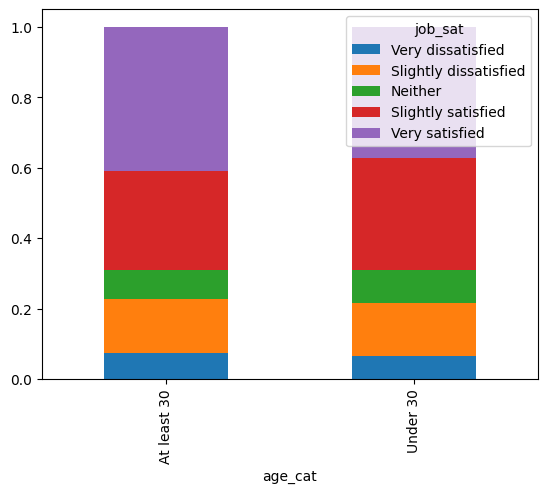

In [289]:
alpha = 0.1
props = stack_overflow.groupby("age_cat", observed=True)["job_sat"].value_counts(
    normalize=True
)
wide_props = props.unstack()
wide_props.plot(kind="bar", stacked=True)
plt.show()

In [290]:
from pingouin import chi2_independence

expected, observed, stats = chi2_independence(
    data=stack_overflow, x="job_sat", y="age_cat"
)
print(stats)

                 test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  5.552373  4.0  0.235164  0.049555  0.437417
1        cressie-read  0.666667  5.554106  4.0  0.235014  0.049563  0.437545
2      log-likelihood  0.000000  5.558529  4.0  0.234632  0.049583  0.437871
3       freeman-tukey -0.500000  5.562688  4.0  0.234274  0.049601  0.438178
4  mod-log-likelihood -1.000000  5.567570  4.0  0.233854  0.049623  0.438538
5              neyman -2.000000  5.579519  4.0  0.232828  0.049676  0.439419


In [291]:
# Swaped variables
from pingouin import chi2_independence

expected, observed, stats = chi2_independence(
    data=stack_overflow, x="age_cat", y="job_sat"
)
print(stats)

                 test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  5.552373  4.0  0.235164  0.049555  0.437417
1        cressie-read  0.666667  5.554106  4.0  0.235014  0.049563  0.437545
2      log-likelihood  0.000000  5.558529  4.0  0.234632  0.049583  0.437871
3       freeman-tukey -0.500000  5.562688  4.0  0.234274  0.049601  0.438178
4  mod-log-likelihood -1.000000  5.567570  4.0  0.233854  0.049623  0.438538
5              neyman -2.000000  5.579519  4.0  0.232828  0.049676  0.439419


Performing a chi-square test
The chi-square independence test compares proportions of successes of one categorical variable across the categories of another categorical variable.

Trade deals often use a form of business shorthand in order to specify the exact details of their contract. These are International Chamber of Commerce (ICC) international commercial terms, or _incoterms_ for short.

The `late_shipments` dataset includes a `vendor_inco_term` that describes the incoterms that applied to a given shipment. The choices are:

- `EXW`: "Ex works". The buyer pays for transportation of the goods.
- `CIP`: "Carriage and insurance paid to". The seller pays for freight and insurance until the goods board a ship.
- `DDP`: "Delivered duty paid". The seller pays for transportation of the goods until they reach a destination port.
- `FCA`: "Free carrier". The seller pays for transportation of the goods.
Perhaps the incoterms affect whether or not the freight costs are expensive. Test these hypotheses with a significance level of `0.01`.

$H_0$: `vendor_inco_term` and `freight_cost_groups` are independent.<br>

$H_A$: `vendor_inco_term` and `freight_cost_groups` are associated.

In [292]:
# Before calculating props, drop rows with NaN in any column
late_shipments.dropna(inplace=True)

In [293]:
# Your proportions calculation remains the same
props = late_shipments.groupby(by="vendor_inco_term")[
    "freight_cost_groups"
].value_counts(normalize=True)
wide_props = props.unstack()

# After unstacking, fill the resulting NaN values with 0
wide_props = wide_props.fillna(0)

print(wide_props)

freight_cost_groups  expensive  reasonable
vendor_inco_term                          
CIP                   0.297872    0.702128
DDP                   0.550000    0.450000
DDU                   0.000000    1.000000
EXW                   0.587143    0.412857
FCA                   0.336449    0.663551


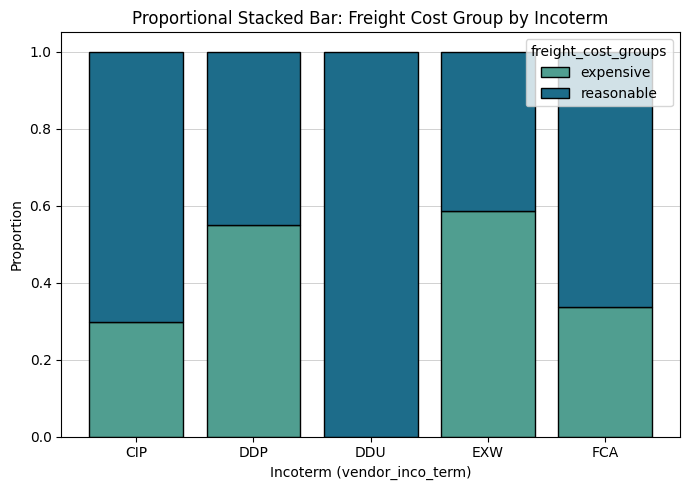

In [294]:
# Proportional stacked bar plot
fig, ax = plt.subplots(figsize=(7, 5))

palette = sns.color_palette("crest", n_colors=wide_props.shape[1])
bottoms = np.zeros(len(wide_props))

for color, col in zip(palette, wide_props.columns):
    ax.bar(
        wide_props.index.astype(str),
        wide_props[col].values,
        bottom=bottoms,
        color=color,
        edgecolor="black",
        label=col,
    )
    bottoms += wide_props[col].values

ax.set(
    xlabel="Incoterm (vendor_inco_term)",
    ylabel="Proportion",
    title="Proportional Stacked Bar: Freight Cost Group by Incoterm",
)

ax.legend(title="freight_cost_groups")
ax.grid(True, axis="y", alpha=0.5, linewidth=0.5, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [295]:
import warnings

from pingouin import chi2_independence

warnings.filterwarnings("ignore")

# Determine if freight_cost_group and vendor_inco_term are independent
expected, observed, stats = chi2_independence(
    data=late_shipments, x="vendor_inco_term", y="freight_cost_groups", correction=False
)

# Print the Pearson chi-square test results
display(stats)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,36.420697,4.0,2.370726e-07,0.195287,0.999517
1,cressie-read,0.666667,36.461778,4.0,2.325010e-07,0.195397,0.999522
2,log-likelihood,0.000000,37.111775,4.0,1.708276e-07,0.197131,0.999603
3,freeman-tukey,-0.500000,NaN,4.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.000000,inf,4.0,0.000000e+00,inf,NaN
5,neyman,-2.000000,NaN,4.0,NaN,NaN,NaN


In [296]:
from scipy.stats import chi2_contingency

# Create contingency table
observed = pd.crosstab(
    index=late_shipments["vendor_inco_term"],
    columns=late_shipments["freight_cost_groups"],
)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(
    observed=observed, correction=False  # Same as pingouin's correction=False
)

# Create results summary
stats = pd.DataFrame(
    {"test": ["pearson"], "lambda": [chi2], "dof": [dof], "pval": [p_value]}
)

display(stats)

,test,lambda,dof,pval
0,pearson,36.420697,4,2.370726e-07


In [297]:
from scipy.stats import chi2_contingency
from scipy.stats.contingency import crosstab

# Create contingency table and perform test in one step
result = crosstab(
    late_shipments["vendor_inco_term"], late_shipments["freight_cost_groups"]
)
contingency_table = result.count

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table, correction=False)

# Create a results DataFrame similar to pingouin
results = pd.DataFrame(
    {"test": ["pearson"], "chi2": [chi2], "p-val": [p_value], "dof": [dof]}
)
display(results)

,test,chi2,p-val,dof
0,pearson,36.420697,2.370726e-07,4


## Goodness of Fit vs. Test of Independence

It is crucial to distinguish between the two main types of chi-square tests:

  * **Chi-Square Test of Independence**: This test involves **two categorical variables** and is used to determine if there is a statistically significant association between them. The expected counts are calculated based on the marginal totals of the sample data itself.

  * **Chi-Square Goodness of Fit Test**: This test involves only **one categorical variable**. It compares the distribution of this variable in a sample to a **pre-defined, external hypothesis** about its distribution in the population. The expected counts are derived from this external hypothesis.

### The Logic of the Goodness of Fit Test

This test evaluates how well a sample of categorical data "fits" a hypothesized distribution.

### Hypotheses

  * **Null Hypothesis ($H_0$)**: The sample data was drawn from a population that has the specified, hypothesized distribution.
  * **Alternative Hypothesis ($H_A$)**: The sample data was *not* drawn from a population with the hypothesized distribution.

The test works by quantifying the discrepancy between the `Observed` counts for each category in your sample and the `Expected` counts you would anticipate under the null hypothesis. This discrepancy is captured by the **chi-square ($\\chi^2$) test statistic**:

$$\chi^2 = \sum_{i=1}^{k} \frac{(\text{Observed}_i - \text{Expected}_i)^2}{\text{Expected}_i}$$

Where the sum is taken over all `k` categories. A small $\\chi^2$ value indicates a good fit between your data and the hypothesis, while a large value indicates a poor fit. The **degrees of freedom** for this test are `k - 1`.


### A Step-by-Step Example

**Scenario**: A company launches a new product and hypothesizes that its market share will be distributed as follows: 40% for their product (Product A), 30% for Competitor B, and 30% for Competitor C. After a month, they take a random sample of 500 recent sales to test this hypothesis.

#### 1. State the Hypothesis and Collect Data

  * **$H_0$**: The market share distribution is 40% for A, 30% for B, and 30% for C.
  * **$H_A$**: The market share distribution is different from the one stated in $H_0$.
  * **Significance Level**: We'll set $\\alpha = 0.05$.


```python
import pandas as pd
import numpy as np
from scipy.stats import chisquare
import matplotlib.pyplot as plt

# 1. Define the hypothesized distribution and sample size 
hypothesized_props = {'Product A': 0.40, 'Product B': 0.30, 'Product C': 0.30}
hypothesized = pd.DataFrame(list(hypothesized_props.items()), columns=['product', 'prop'])
n_total = 500

# 2. Create sample data with observed counts
# In a real scenario, this data would be collected. We will simulate it.
np.random.seed(42)
observed_data = pd.DataFrame({
    'product': np.random.choice(list(hypothesized_props.keys()), n_total, p=[0.45, 0.28, 0.27])
})
observed_counts = observed_data['product'].value_counts().reset_index()
observed_counts.columns = ['product', 'n']
# Ensure the order of products matches for comparison
observed_counts = observed_counts.sort_values('product').reset_index(drop=True)

print(observed_counts)
```

#### 2. Calculate Expected Counts

The expected count for each category is its hypothesized proportion multiplied by the total sample size.

```python
# Calculate the expected counts based on the null hypothesis
hypothesized['n'] = hypothesized['prop'] * n_total

print(hypothesized)
```

#### 3. Visualize the Counts

A bar chart is an effective way to visually compare the observed counts from our sample to the counts we would have expected under the null hypothesis.

```python
# Visualize the comparison using seaborn 
import seaborn as sns

# Ensure consistent product order
product_order = observed_counts['product'].tolist()

# Prepare data for seaborn
obs = observed_counts[['product', 'n']].assign(group='Observed')
exp = hypothesized[['product', 'n']].sort_values('product').assign(group='Hypothesized')
plot_df = pd.concat([obs, exp], ignore_index=True)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    data=plot_df,
    x='product',
    y='n',
    hue='group',
    order=product_order,
    ax=ax,
    palette={'Observed': 'skyblue', 'Hypothesized': 'salmon'},
    edgecolor='black'
)

ax.set_title("Observed vs. Hypothesized Counts")
ax.set_xlabel("Product")
ax.set_ylabel("Number of Sales")
ax.legend(title="")
plt.tight_layout()
plt.show()
```

#### 4. Perform the Test and Make a Decision

The `scipy.stats.chisquare()` function performs the goodness of fit test directly. It takes the observed counts (`f_obs`) and the expected counts (`f_exp`) as arguments.

```python
from scipy.stats import chisquare
# Perform the chi-square goodness of fit test 
# The function requires the counts to be in the same order.
chi2_stat, p_value = chisquare(
    f_obs=observed_counts['n'],
    f_exp=hypothesized['n']
)

print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Make a statistical decision
if p_value < alpha:
    print(f"\nDecision: Reject H0, because p-value ({p_value:.4f}) < alpha ({alpha}).")
    print("The sample data distribution does not match the hypothesized distribution.")
else:
    print(f"\nDecision: Fail to reject H0, because p-value ({p_value:.4f}) >= alpha ({alpha}).")
    print("There is not enough evidence to conclude the distributions are different.")
```

In this case, the p-value is large, so we fail to reject the null hypothesis. The observed differences between our sample and the company's hypothesized market share are small enough that they could plausibly be due to random sampling variability.

In [298]:
purple_link_counts = stack_overflow["purple_link"].value_counts()
display(purple_link_counts)

purple_link
Hello, old friend    1225
Indifferent           405
Amused                368
Annoyed               263
Name: count, dtype: int64

In [299]:
purple_link_counts = (
    purple_link_counts.rename_axis("purple_link")
    .reset_index(name="n")
    .sort_values(by="purple_link")
)
display(purple_link_counts)

,purple_link,n
2,Amused,368
3,Annoyed,263
0,"Hello, old friend",1225
1,Indifferent,405


In [300]:
hypothesized = pd.DataFrame(
    {
        "purple_link": ["Amused", "Annoyed", "Hello, old friend", "Indifferent"],
        "prop": [1 / 6, 1 / 6, 1 / 2, 1 / 6],
    }
)
display(hypothesized)

,purple_link,prop
0,Amused,0.166667
1,Annoyed,0.166667
2,"Hello, old friend",0.500000
3,Indifferent,0.166667


In [301]:
alpha = 0.01
n_total = len(stack_overflow)
hypothesized["n"] = hypothesized["prop"] * n_total
display(hypothesized)

,purple_link,prop,n
0,Amused,0.166667,376.833333
1,Annoyed,0.166667,376.833333
2,"Hello, old friend",0.500000,1130.500000
3,Indifferent,0.166667,376.833333


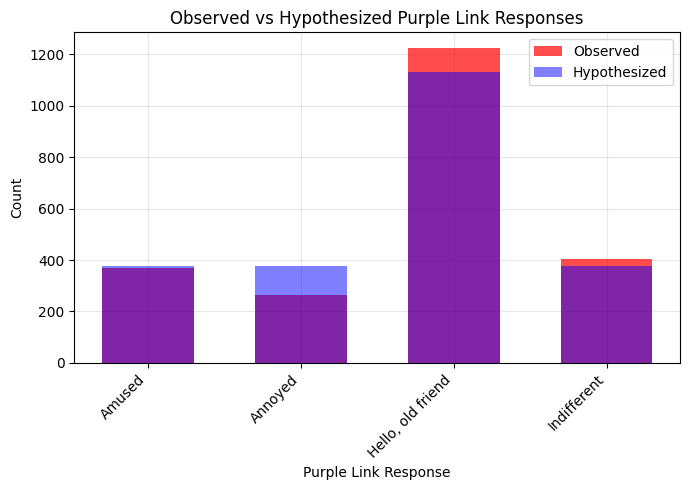

In [302]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))

# Create bar positions
x_pos = range(len(purple_link_counts))

# Plot observed counts
ax.bar(
    x_pos, purple_link_counts["n"], color="red", alpha=0.7, label="Observed", width=0.6
)

# Plot hypothesized counts with transparency
ax.bar(
    x_pos, hypothesized["n"], color="blue", alpha=0.5, label="Hypothesized", width=0.6
)

# Set x-axis labels
ax.set_xticks(x_pos)
ax.set_xticklabels(purple_link_counts["purple_link"], rotation=45, ha="right")

# Labels and formatting
ax.set_xlabel("Purple Link Response")
ax.set_ylabel("Count")
ax.set_title("Observed vs Hypothesized Purple Link Responses")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [303]:
from scipy.stats import chisquare

chisquare(f_obs=purple_link_counts["n"], f_exp=hypothesized["n"])

Power_divergenceResult(statistic=np.float64(44.59840778416629), pvalue=np.float64(1.1261810719413759e-09))

In [304]:
# Find the number of rows in late_shipments
incoterm_counts = late_shipments["vendor_inco_term"].value_counts()

incoterm_counts = (
    incoterm_counts.rename_axis("vendor_inco_term")
    .reset_index(name="n")
    .sort_values(by="vendor_inco_term")
).drop(index=4, axis=0)

In [305]:
hypothesized = pd.DataFrame(
    {
        "vendor_inco_term": ["CIP", "DDP", "EXW", "FCA"],
        "prop": [1 / 6, 1 / 6, 1 / 2, 1 / 6],
    }
)
hypothesized["n"] = hypothesized["prop"] * len(late_shipments)
display(hypothesized)

,vendor_inco_term,prop,n
0,CIP,0.166667,159.166667
1,DDP,0.166667,159.166667
2,EXW,0.500000,477.500000
3,FCA,0.166667,159.166667


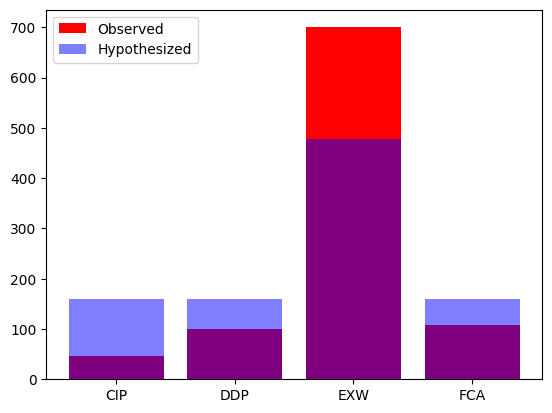

In [306]:
# Plot a red bar graph of n vs. vendor_inco_term for incoterm_counts
plt.bar(
    incoterm_counts["vendor_inco_term"],
    incoterm_counts["n"],
    color="red",
    label="Observed",
)

# Add a blue bar plot for the hypothesized counts
plt.bar(
    hypothesized["vendor_inco_term"],
    hypothesized["n"],
    color="blue",
    alpha=0.5,
    label="Hypothesized",
)
plt.legend()
plt.show()

```python
# Perform a goodness of fit test on the incoterm counts n
gof_test = chisquare(f_obs=incoterm_counts["n"], f_exp=hypothesized["n"])

# Extract the test statistic and p-value
chi2_stat, p_value = gof_test

# Print gof_test results
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.6f}")

# Set significance level and make decision
alpha = 0.05
if p_value < alpha:
    print(f"\nDecision: Reject H0 (p-value {p_value:.6f} < α {alpha})")
    print(
        "The observed incoterm distribution differs significantly from the hypothesized distribution."
    )
else:
    print(f"\nDecision: Fail to reject H0 (p-value {p_value:.6f} >= α {alpha})")
    print(
        "There is insufficient evidence that the incoterm distribution differs from the hypothesis."
    )

## Assumptions in Hypothesis Testing

The validity of standard hypothesis tests, including t-tests, proportion tests, and chi-square tests, relies on three core assumptions about your data: that it was collected **randomly**, that the individual observations are **independent**, and that the **sample size is sufficiently large**. Violating these assumptions can lead to incorrect calculations and invalid statistical conclusions.

### 1. Randomness

  * **Assumption**: The sample data must be a random subset of the population of interest. This means every individual in the population had an equal chance of being selected.

  * **Consequences of Violation**: If the sample is not random (e.g., it's a convenience sample), it is likely not representative of the population. This introduces **sample bias**, meaning any conclusions you draw from the test may not apply to the broader population you are trying to understand.

  * **How to Check**: This assumption cannot be verified with code. It is a **methodological** check that requires you to understand how the data was collected. You must confirm that a proper randomization procedure was used. A code demonstration can, however, show the *effect* of a biased sample.

```python
import numpy as np
import pandas as pd

# Population with a true mean of 100
population = pd.DataFrame({'value': np.random.normal(loc=100, scale=20, size=10000)})
# A biased sample that only includes values greater than the mean
biased_sample = population[population['value'] > 100].sample(n=100, random_state=42)

print(f"True Population Mean: {population['value'].mean():.2f}")
print(f"Biased Sample Mean: {biased_sample['value'].mean():.2f}")
# The biased sample mean is a poor estimate of the population mean.
```

### 2. Independence of Observations

  * **Assumption**: Each observation (row) in the dataset must be independent of the others. This means the value of one observation does not influence the value of another.

  * **Consequences of Violation**: If observations are dependent (e.g., measuring the same person's performance over several consecutive days), the sample contains less unique information than its size suggests. This can artificially reduce the calculated standard error, leading to an inflated test statistic and an an increased probability of a **false positive (Type I error)**.

  * **How to Check**: Like randomness, this is primarily a check of the data collection methodology. For data collected over time (time-series data), you can diagnose a lack of independence by checking for **autocorrelation** (whether an observation is correlated with preceding observations).


```python
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Create a non-independent (autocorrelated) series
np.random.seed(42)
non_independent_data = [50]
for _ in range(99):
    non_independent_data.append(non_independent_data[-1] + np.random.normal(0, 5))

# A plot showing significant correlation at various lags indicates non-independence
plot_acf(pd.Series(non_independent_data))
plt.title("Autocorrelation Plot for Non-Independent Data")
plt.show()
```

### 3. Large Sample Size

  * **Assumption**: The sample size must be large enough for the Central Limit Theorem to apply, which ensures that the sampling distribution of the test statistic is well-approximated by its theoretical distribution (e.g., normal or t-distribution).

  * **Consequences of Violation**: With small samples, the test may lack statistical power (increasing the chance of a **false negative (Type II error)**), and the calculated p-values may not be reliable.

  * **How to Check**: The rule of thumb for a "large enough" sample size depends on the type of test being performed.

### T-tests (One-sample, Two-sample, Paired, ANOVA)

The sample size `n` (or the size of each sample, $n_i$) should be **at least 30**. 

```python
# Check for a two-sample t-test
# Assume 'df' has a 'group' column and 'value' column
group_sizes = df.groupby('group')['value'].count()
print(group_sizes)
print(group_sizes >= 30)
```

#### Proportion Tests

The number of **successes** and **failures** in each sample must be **at least 10**. 

```python
# Check for a one-sample proportion test
n = len(sample_data)
p_hat = sample_data['outcome'].mean()
successes = n * p_hat
failures = n * (1 - p_hat)
print(f"Successes: {successes}, Failures: {failures}")
print(f"Conditions met: {successes >= 10 and failures >= 10}")
```

#### Chi-square Tests

The **expected count** for each cell in the contingency table must be **at least 5**.

```python
import pingouin

# Check for a chi-square test of independence
# Assume 'df' has two categorical columns: 'cat1' and 'cat2'
expected, observed, stats = pingouin.chi2_independence(data=df, x='cat1', y='cat2')
print(f"Minimum expected count: {expected.min().min()}")
print(f"Condition met: {expected.min().min() >= 5}")
```



### Large Sample Hypothesis Test Requirements

#### t-tests

| Test Type       | Condition                                                               |
| --------------- | ----------------------------------------------------------------------- |
| **One sample**  | At least 30 observations in the sample (*n ≥ 30*)                       |
| **Two samples** | At least 30 observations in each sample (*n₁ ≥ 30, n₂ ≥ 30*)            |
| **Paired**      | At least 30 pairs of observations across the samples (*rows ≥ 30*)      |
| **ANOVA**       | At least 30 observations in each sample (*nᵢ ≥ 30 for all values of i*) |


#### Proportion tests

| Test Type       | Condition                                                                                                                                                           |
| --------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **One sample**  | - Number of successes ≥ 10 (*n × p̂ ≥ 10*)<br>- Number of failures ≥ 10 (*n × (1 - p̂) ≥ 10*)                                                                       |
| **Two samples** | - Number of successes in each sample ≥ 10 (*n₁ × p̂₁ ≥ 10, n₂ × p̂₂ ≥ 10*)<br>- Number of failures in each sample ≥ 10 (*n₁ × (1 - p̂₁) ≥ 10, n₂ × (1 - p̂₂) ≥ 10*) |


#### Chi-square tests

| Test Type      | Condition                                                                                                                                                         |
| -------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Chi-square** | - Number of successes in each group ≥ 5 (*nᵢ × p̂ᵢ ≥ 5 for all values of i*)<br>- Number of failures in each group ≥ 5 (*nᵢ × (1 - p̂ᵢ) ≥ 5 for all values of i*) |


### A Final Sanity Check

If you are unsure whether your assumptions are met, you can generate a bootstrap distribution of your statistic. If the resulting histogram does not look reasonably symmetric and bell-shaped, it's a strong indicator that the sample size may be too small or other assumptions are violated, and the results of your formal hypothesis test should be interpreted with caution.

#### Test Statistic Formulas (Large Sample)

| Test Family | Test Type | Test Statistic Formula |
| --- | --- | --- |
| **t-test** | One sample | $t = \frac{\bar{X} - \mu_0}{s / \sqrt{n}}$ |
|  | Two samples (independent) | $t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$ |
|  | Paired samples | $t = \frac{\bar{D}}{s_D / \sqrt{n}}$, where $\bar{D}$ = mean of differences |
|  | ANOVA (k groups) | $\large F = \frac{\text{MS}_{\text{between}}}{\text{MS}_{\text{within}}}$ |
| **Proportion** | One sample | $z = \frac{\hat{p} - p_0}{\sqrt{p_0(1 - p_0)/n}}$ |
|  | Two samples | $z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1 - \hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}$, with pooled $\hat{p}$ |
| **Chi-square** | Goodness of Fit | $\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}$ |
|  | Independence | $\chi^2 = \sum \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$, where  $E_{ij} = \frac{(\text{row total})(\text{col total})}{N}$ |

This one is the **mathematical reference card**:

- $\bar{X}$ = sample mean
- $\mu_0$ = hypothesised population mean
- $s$ = sample standard deviation
- $n$ = sample size
- $\hat{p}$ = sample proportion
- $O$ = observed frequency, $E$ = expected frequency

In [307]:
# Count the freight_cost_group values
counts = late_shipments["freight_cost_groups"].value_counts()

# Inspect whether the counts are big enough
print((counts >= 30).all())

True


In [308]:
# Get the count of each value in the late column of late_shipments
counts = late_shipments["late"].value_counts()

# Inspect whether the counts are big enough
print((counts >= 10).all())

True


In [309]:
# Count the values of freight_cost_group grouped by vendor_inco_term
counts = late_shipments.groupby("vendor_inco_term")[
    "freight_cost_groups"
].value_counts()

print((counts >= 5).all())

False


In [310]:
# Count the shipment_mode values
counts = late_shipments["shipment_mode"].value_counts()


# Inspect whether the counts are big enough
print((counts >= 30).all())

False


## The Limits of Parametric Tests

Hypothesis tests like the z-test, t-test, and ANOVA are **parametric**. This means they make certain assumptions about the parameters of the population distribution from which the sample is drawn. The most common and critical assumption is that the data (or, more formally, the sampling distribution of the statistic) follows a normal distribution.

These tests rely on the Central Limit Theorem to ensure this normality assumption holds, which requires a **sufficiently large sample size** (e.g., n ≥ 30 for t-tests). When these assumptions are violated, particularly when dealing with small samples or heavily skewed data, the results of parametric tests may be unreliable.

### Non-Parametric Tests: A Distribution-Free Approach

Non-parametric tests are a powerful alternative when the assumptions of parametric tests are not met. They are often called "distribution-free" because they do not rely on assumptions about the underlying population distribution.

Many non-parametric tests achieve this by working with the **ranks** of the data rather than the raw data values themselves. Ranking converts the data into an ordinal scale, which preserves information about the order and relative magnitude of the observations but is insensitive to the specific distribution shape and the influence of outliers.

```python
from scipy.stats import rankdata

# A sample of raw data
raw_data = [12.5, 30.1, 5.8, 25.5, 18.0]

# Convert the data to ranks
ranked_data = rankdata(raw_data)

print(f"Original Data: {raw_data}")
print(f"Ranked Data:   {ranked_data}")
```

### The Wilcoxon Signed-Rank Test

The **Wilcoxon signed-rank test** is the non-parametric alternative to the **paired t-test**. It is used to determine if there is a significant difference between two related, paired samples, and it is particularly reliable for small sample sizes.

#### The Logic of the Test

Instead of working with the raw values, the test analyzes the ranks of the differences between pairs. The process is as follows:

1.  Calculate the **difference** between each pair of observations.
2.  Calculate the **absolute value** of these differences.
3.  **Rank** the non-zero absolute differences from smallest to largest.
4.  The test statistic, `W`, is calculated from the sum of the ranks corresponding to the original positive differences and the sum of the ranks corresponding to the original negative differences. It effectively tests whether there is a systematic tendency for the differences to be positive or negative.

### Implementation in Python

While the manual calculation is insightful, the `pingouin` library provides a direct and convenient function for performing this test: `pingouin.wilcoxon()`.

#### A Complete Example

**Scenario**: A company tests a new website design on a small group of 12 users. They measure each user's engagement score on the old design and the new design. We want to know if the new design significantly increased engagement. Our sample size is too small for a paired t-test to be reliable.

```python
import pandas as pd
import numpy as np
import pingouin

# 1. Create a small, synthetic paired dataset (n=12)
np.random.seed(42)
df = pd.DataFrame({
    'old_design_score': np.random.normal(loc=70, scale=10, size=12),
    'new_design_score': np.random.normal(loc=78, scale=12, size=12)
})

# 2. State Hypotheses and Significance Level
# H0: The median difference between new and old scores is zero.
# HA: The median new score is greater than the median old score.
# This is a right-tailed test.
alpha = 0.05

# 3. Perform the Wilcoxon signed-rank test
# The syntax is very similar to pingouin.ttest()
# For a paired test, we provide x and y.
wilcoxon_results = pingouin.wilcoxon(
    x=df['new_design_score'],
    y=df['old_design_score'],
    alternative='greater' # 'greater' corresponds to HA: new > old
)

print(wilcoxon_results)

# 4. Make a Statistical Decision
p_value = wilcoxon_results['p-val'].iloc[0]

if p_value < alpha:
    print(f"Decision: Reject H0, because p-value ({p_value:.4f}) < alpha ({alpha}).")
    print("The evidence suggests the new design significantly increased engagement scores.")
else:
    print(f"Decision: Fail to reject H0, because p-value ({p_value:.4f}) >= alpha ({alpha}).")
    print("There is not enough evidence to conclude a significant increase in engagement.")
```

The Wilcoxon signed-rank test provides a robust method for comparing paired samples without relying on the strict assumptions of the paired t-test, making it an essential tool for working with small or non-normally distributed datasets.

In [311]:
# repub_votes.sample(5, random_state=42) picks 5 random rows (reproducible seed); Stats: a small random sample gives a quick, unbiased peek at data variability and structure.
repub_votes_small = repub_votes.sample(5, random_state=42)

display(repub_votes_small)

,state,county,repub_percent_08,repub_percent_12,diff
83,Texas,Terrell,62.235067,64.504505,-2.269437
53,New Mexico,Eddy,62.210720,65.301780,-3.091060
70,South Dakota,Bon Homme,54.942234,59.531555,-4.589321
45,Missouri,Montgomery,58.538251,65.515299,-6.977048
44,Missouri,Iron,47.349343,55.867031,-8.517688


In [312]:
# Set the significance level (alpha) for the hypothesis test; probability of Type I error (rejecting H0 when true)
alpha = 0.01

# Perform a paired t-test comparing Republican vote percentages in 2008 and 2012
# x: first sample (2008 percentages), y: second sample (2012 percentages)
# paired=True: indicates paired samples (same counties in both years)
# alternative="less": tests if the mean of x is less than the mean of y (one-tailed test)
pingouin.ttest(
    x=repub_votes_small["repub_percent_08"],
    y=repub_votes_small["repub_percent_12"],
    paired=True,
    alternative="less",
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.338891,4,less,0.006132,"[-inf, -2.59]",0.954471,12.165,0.54747


### Wilcoxon-signed rank test (Step 1)


**Test Statistic (W)**

The test statistic $W$ is the minimum of the sum of positive ranks ($W^{+}$) and the sum of negative ranks ($W^{-}$):

$$
W = \min\left(W^{+}, W^{-}\right)
$$

**Where:**
- **Sum of positive ranks ($W^{+}$):**
  $$
  W^{+} = \sum_{i=1}^{N\_r} R\_i \cdot \mathbf{1}(d\_i > 0)
  $$
- **Sum of negative ranks ($W^{-}$):**
  $$
  W^{-} = \sum_{i=1}^{N\_r} R\_i \cdot \mathbf{1}(d\_i < 0)
  $$

**Notes:**
- ( $N_r$ ) is the number of **nonzero** paired differences.
- ( $R_i$ ) is the rank of the absolute difference ( $|d_i|$ ).
- ( $\mathbf{1}(\cdot)$) denotes the indicator function (equals 1 if the condition is true, 0 otherwise).

In [313]:
# Calculate the difference in Republican vote percentages between 2008 and 2012 for each county
repub_votes_small["diff"] = (
    repub_votes_small["repub_percent_08"] - repub_votes_small["repub_percent_12"]
)

display(repub_votes_small)

,state,county,repub_percent_08,repub_percent_12,diff
83,Texas,Terrell,62.235067,64.504505,-2.269437
53,New Mexico,Eddy,62.210720,65.301780,-3.091060
70,South Dakota,Bon Homme,54.942234,59.531555,-4.589321
45,Missouri,Montgomery,58.538251,65.515299,-6.977048
44,Missouri,Iron,47.349343,55.867031,-8.517688


### Wilcoxon-signed rank test (Steр 2)


In [314]:
# Compute the absolute value of the differences; ranks are based on absolute differences (ignores direction of change)
repub_votes_small["abs_diff"] = repub_votes_small["diff"].abs()

display(repub_votes_small)

,state,county,repub_percent_08,repub_percent_12,diff,abs_diff
83,Texas,Terrell,62.235067,64.504505,-2.269437,2.269437
53,New Mexico,Eddy,62.210720,65.301780,-3.091060,3.091060
70,South Dakota,Bon Homme,54.942234,59.531555,-4.589321,4.589321
45,Missouri,Montgomery,58.538251,65.515299,-6.977048,6.977048
44,Missouri,Iron,47.349343,55.867031,-8.517688,8.517688


### Wilcoxon-signed rank test (Steр 3)


In [315]:
from scipy.stats import rankdata

# Rank the absolute differences; ranks are assigned to the absolute values of differences (smallest = rank 1)
repub_votes_small["rank_abs_diff"] = rankdata(repub_votes_small["abs_diff"])

display(repub_votes_small)

,state,county,repub_percent_08,repub_percent_12,diff,abs_diff,rank_abs_diff
83,Texas,Terrell,62.235067,64.504505,-2.269437,2.269437,1.0
53,New Mexico,Eddy,62.210720,65.301780,-3.091060,3.091060,2.0
70,South Dakota,Bon Homme,54.942234,59.531555,-4.589321,4.589321,3.0
45,Missouri,Montgomery,58.538251,65.515299,-6.977048,6.977048,4.0
44,Missouri,Iron,47.349343,55.867031,-8.517688,8.517688,5.0


### Wilcoxon-signed rank test (Steр 4)
- Incorporate the sum of the ranks for negative and positive differences


In [316]:
# Calculate the sum of ranks for negative differences (T-); ranks of counties where 2008 > 2012
T_minus = repub_votes_small.loc[repub_votes_small["diff"] < 0, "rank_abs_diff"].sum()

# Calculate the sum of ranks for positive differences (T+); ranks of counties where 2008 < 2012
T_plus = repub_votes_small.loc[repub_votes_small["diff"] > 0, "rank_abs_diff"].sum()

# Wilcoxon test statistic (W): minimum of T- and T+; tests symmetry of differences around zero
W = np.min([T_minus, T_plus])

# Print the Wilcoxon test statistic (W); smaller value indicates stronger evidence against H0
print(W)

0.0


### Implementation with `pingouin.wilcoxon()`

In [317]:
# Set the significance level (alpha) for the hypothesis test; probability of Type I error (rejecting H0 when true)
alpha = 0.01

# Perform the Wilcoxon signed-rank test for paired samples
# x, y: paired samples (2008 and 2012 Republican vote percentages)
# alternative="less": tests if the median of x is less than the median of y (one-tailed test)
pingouin.wilcoxon(
    x=repub_votes_small["repub_percent_08"],
    y=repub_votes_small["repub_percent_12"],
    alternative="less",
)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,0.0,less,0.03125,-1.0,0.8


In [318]:
sample_dem_data

,state,county,dem_percent_12,dem_percent_16,diff
0,Alabama,Bullock,76.305900,74.946921,1.358979
1,Alabama,Chilton,19.453671,15.847352,3.606319
2,Alabama,Clay,26.673672,18.674517,7.999155
3,Alabama,Cullman,14.661752,10.028252,4.633500
4,Alabama,Escambia,36.915731,31.020546,5.895185
...,...,...,...,...,...
495,Wyoming,Uinta,19.065464,14.191263,4.874201
496,Wyoming,Washakie,20.131846,13.948610,6.183235
497,Alaska,District 3,33.514582,16.301064,17.213518
498,Alaska,District 18,61.284271,52.810051,8.474220


In [319]:
url = "https://assets.datacamp.com/production/repositories/5982/datasets/4ab6431d773d1fe659ac120b4b49a1b525a76712/dem_votes_potus_12_16.feather"
sample_dem_data = pd.read_feather(url)
sample_dem_data.head()

,state,county,dem_percent_12,dem_percent_16
0,Alabama,Bullock,76.305900,74.946921
1,Alabama,Chilton,19.453671,15.847352
2,Alabama,Clay,26.673672,18.674517
3,Alabama,Cullman,14.661752,10.028252
4,Alabama,Escambia,36.915731,31.020546


In [320]:
# Perform a paired t-test to compare means of two related samples (2012 vs. 2016 Democratic vote percentages)
paired_test_results = pingouin.ttest(
    x=sample_dem_data["dem_percent_12"],
    y=sample_dem_data["dem_percent_16"],
    alternative="two-sided",
    paired=True,
)

# t-test results (includes t-statistic, p-value, and confidence intervals)
display(paired_test_results)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,30.298384,499,two-sided,3.600634e-115,"[6.39, 7.27]",0.454202,2.246e+111,1.0


In [321]:
# Conduct a Wilcoxon test on dem_percent_12 and dem_percent_16
wilcoxon_test_results = pingouin.wilcoxon(
    x=sample_dem_data["dem_percent_12"],
    y=sample_dem_data["dem_percent_16"],
    alternative="two-sided",
)


# Print Wilcoxon test results
display(wilcoxon_test_results)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,2401.0,two-sided,1.780396e-77,0.961661,0.644816


## Non-Parametric Tests for Independent (Unpaired) Samples

While the Wilcoxon signed-rank test is the appropriate non-parametric tool for *paired* data, we need different tests for comparing **independent groups**. These tests are essential when the assumptions of parametric tests are not met, such as when the data is not normally distributed or when sample sizes are small.

### The Mann-Whitney U Test (Wilcoxon-Mann-Whitney)

The **Mann-Whitney U test** (also known as the Wilcoxon-Mann-Whitney test) is the non-parametric alternative to the **independent two-sample t-test**. It is used to determine if there is a significant difference between the distributions of two independent groups.

#### The Logic of the Test

The test does not compare the means of the groups directly. Instead, it works with the **ranks** of the data:

1.  All observations from both groups are combined into a single dataset.
2.  These combined observations are ranked from smallest to largest.
3.  The test then compares the sum of the ranks for each of the two groups.

The null hypothesis ($H_0$) is that the two distributions are identical. If this is true, the ranks should be randomly mixed between the two groups, and their sum of ranks should be similar. A large difference in the sum of ranks provides evidence against the null hypothesis.

#### Implementation in `pingouin`

The `pingouin.mwu()` function performs this test. It requires the data for the two groups, `x` and `y`, to be provided as separate arrays or Series without missing values.

```python
import pandas as pd
import numpy as np
import pingouin

# Create a generic, reproducible dataset with two independent groups
# We will use a skewed distribution (log-normal) where a t-test might be inappropriate.
np.random.seed(42)
df_two_groups = pd.DataFrame({
    'group': ['Group A'] * 40 + ['Group B'] * 50,
    'value': np.concatenate([
        np.random.lognormal(mean=3.0, sigma=0.5, size=40),
        np.random.lognormal(mean=3.2, sigma=0.5, size=50)
    ])
})

# Prepare the data for pingouin.mwu() by separating the groups
group_a_values = df_two_groups[df_two_groups['group'] == 'Group A']['value']
group_b_values = df_two_groups[df_two_groups['group'] == 'Group B']['value']

# Perform the Mann-Whitney U test
# HA: The distribution of Group B is greater than Group A
mwu_results = pingouin.mwu(x=group_b_values, y=group_a_values, alternative='greater')

print(mwu_results)
```

### The Kruskal-Wallis Test

The relationship between the **Kruskal-Wallis test** and the Mann-Whitney U test is analogous to the relationship between ANOVA and the t-test. The Kruskal-Wallis test is the non-parametric alternative to the **one-way ANOVA**.

#### The Logic of the Test

It is an omnibus test used to determine if there are statistically significant differences between the distributions of **three or more independent groups**. Its logic is an extension of the Mann-Whitney U test: it pools all data, ranks it, and then compares the average rank for each group.

  * **Null Hypothesis ($H_0$)**: The distributions of all groups are identical.
  * **Alternative Hypothesis ($H_A$)**: At least one group's distribution is different from the others.

### Implementation in `pingouin`

The `pingouin.kruskal()` function performs this test, using a syntax similar to `pingouin.anova()`.

```python
# Create a dataset with three independent groups
np.random.seed(42)
df_three_groups = pd.DataFrame({
    'group': ['Group A'] * 40 + ['Group B'] * 50 + ['Group C'] * 45,
    'value': np.concatenate([
        np.random.lognormal(mean=3.0, sigma=0.5, size=40),
        np.random.lognormal(mean=3.2, sigma=0.5, size=50),
        np.random.lognormal(mean=3.0, sigma=0.5, size=45) # A and C are similar
    ])
})

# Perform the Kruskal-Wallis test 
kruskal_results = pingouin.kruskal(data=df_three_groups, dv='value', between='group')

print(kruskal_results)

# Interpretation 
alpha = 0.05
p_value = kruskal_results['p-unc'].iloc[0]

if p_value < alpha:
    print(f"Decision: Reject H0, because p-value ({p_value:.4f}) < alpha ({alpha}).")
    print("The evidence suggests at least one group has a different distribution.")
else:
    print(f"Decision: Fail to reject H0, because p-value ({p_value:.4f}) >= alpha ({alpha}).")
    print("There is not enough evidence to conclude the distributions are different.")
```

A significant result from the Kruskal-Wallis test indicates that a difference exists somewhere among the groups. To determine which specific pairs of groups are different, one would then perform post-hoc tests (such as Dunn's test), which are the non-parametric equivalent of the pairwise t-tests that follow an ANOVA.

In [322]:
age_vs_comp = stack_overflow[["converted_comp", "age_first_code_cut"]]
age_vs_comp_wide = age_vs_comp.pivot(
    columns="age_first_code_cut", values="converted_comp"
)
display(age_vs_comp_wide)

age_first_code_cut,adult,child
0,77556.0,NaN
1,NaN,74970.0
2,NaN,594539.0
3,2000000.0,NaN
4,37816.0,NaN
...,...,...
2256,NaN,145000.0
2257,NaN,33972.0
2258,NaN,97284.0
2259,NaN,72000.0


### Wilcoxon-Mann-Whitney test
We can avoid assumptions about normally distributed data by performing hypothesis tests on the ranks of a numeric input.
The Wilcoxon-Mann-Whitney test is, very roughly speaking, a t-test on ranked data. 


$$U_1 = R_1 - \frac{n_1(n_1 + 1)}{2}, \quad 
U_2 = R_2 - \frac{n_2(n_2 + 1)}{2}$$

$$U = \min(U_1, U_2)$$

**Wilcoxon Rank-Sum:**
$$W = \min(W_1, W_2)$$
where $W_1 = R_1$ and $W_2 = R_2$ (sum of ranks for samples 1 and 2).

### Normal Approximation (No Ties)
$$z = \frac{U - \mu_U}{\sigma_U}$$
with:
$$\mu_U = \frac{n_1 n_2}{2}, \quad 
\sigma_U = \sqrt{\frac{n_1 n_2 (n_1 + n_2 + 1)}{12}}$$

### Tie Correction
With tied ranks, adjust $\sigma_U$:
$$\sigma_U = \sqrt{\frac{n_1 n_2}{12} \left( (n_1 + n_2 + 1) - \frac{\sum_{k=1}^{K} (t_k^3 - t_k)}{(n_1 + n_2)(n_1 + n_2 - 1)} \right)}$$
where $t_k$ = number of ties in the $k$-th group of tied ranks.


In [323]:
alpha = 0.01

pingouin.mwu(
    x=age_vs_comp_wide["child"], y=age_vs_comp_wide["adult"], alternative="greater"
)

,U-val,alternative,p-val,RBC,CLES
MWU,744365.5,greater,1.902723e-19,0.222516,0.611258


### Kruskal-Wallis test

In the same way that ANOVA extends t-tests to more than two groups, the Kruskal-Wallis test extends the Wilcoxon-Mann-Whitney test to more than two groups. That is, the Kruskal-Wallis test is a non-parametric version of ANOVA.

In [324]:
alpha = 0.01
pingouin.kruskal(data=stack_overflow, dv="converted_comp", between="job_sat")

,Source,ddof1,H,p-unc
Kruskal,job_sat,4,72.814939,5.772915e-15


In [325]:
weight_vs_late = late_shipments[["weight_kilograms", "late"]]

# Reshape the data into a wide format with separate columns for "Yes" and "No" late shipments
weight_vs_late_table = weight_vs_late.pivot(columns="late", values="weight_kilograms")

# Null Hypothesis (H0): The distributions of weights are identical for late and non-late shipments
wmw_test = pingouin.mwu(
    x=weight_vs_late_table["Yes"],
    y=weight_vs_late_table["No"],
    alternative="two-sided",
)

display(wmw_test)

,U-val,alternative,p-val,RBC,CLES
MWU,34518.0,two-sided,0.00001,0.348728,0.674364


In [326]:
# Perform a Kruskal-Wallis test: a non-parametric alternative to one-way ANOVA for comparing medians across groups
kw_test = pingouin.kruskal(
    data=late_shipments, dv="weight_kilograms", between="shipment_mode"
)

# Display the test results, including H-statistic, degrees of freedom, and p-value
display(kw_test)

,Source,ddof1,H,p-unc
Kruskal,shipment_mode,2,124.608806,8.740607e-28
